# **Soal 3 - GAN**

# **2702265641 - Tiffanny Felita**

**Link Video** : https://youtu.be/WK2YoUfdZXE

**Karena dataset yang digunakan sama seperti pada nomor 2 dan sudah bersih (tidak mengandung missing values maupun data yang rusak), maka tahap eksplorasi data (EDA) tidak dijelaskan ulang di sini dan langsung dilanjutkan ke tahap preprocessing.**


**GAN (Generative Adversarial Network)** adalah model deep learning dengan dua jaringan: **generator** yang membuat data palsu dan **discriminator** yang membedakannya dari data asli. Keduanya dilatih bersama hingga generator mampu menghasilkan data yang menyerupai data asli.


# **Import Library**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
import cv2
import zipfile
from tensorflow.keras import backend as K
K.clear_session()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_path = '/content/drive/MyDrive/DeepLearning/B_23.zip'
extract_base_path = '/content/dataset/' # Path dasar untuk ekstraksi

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print(f"Isi dari {extract_base_path}: {os.listdir(extract_base_path)}")

Isi dari /content/dataset/: ['B_23']


In [4]:
data_folder = os.path.join(extract_base_path, 'B_23')

image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
images = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
images = np.array(images)

print(f"Total gambar yang dimuat: {len(images)}")
if len(images) > 0:
    print(f"Dimensi gambar pertama (contoh): {images[0].shape}")
else:
    print("Tidak ada gambar yang ditemukan. Pastikan path folder sudah benar dan berisi gambar.")

Total gambar yang dimuat: 1074
Dimensi gambar pertama (contoh): (600, 600, 3)


# **Preprocessing**

In [5]:
images_resized = tf.image.resize(images, (100, 100)).numpy()

# Normalisasi ke [-1, 1]
real_images = (images_resized.astype('float32') / 127.5) - 1.0

# Cek ulang
print(real_images.shape)          # (1074, 100, 100, 3)
print(real_images.dtype)          # float32
print(np.min(real_images), np.max(real_images))  # Harus sekitar -1.0 ~ 1.0

(1074, 100, 100, 3)
float32
-1.0 1.0


Dataset terdiri dari **1074 gambar berwarna berukuran 100×100 piksel** dengan **3 channel (RGB)**, disimpan dalam format **float32** untuk efisiensi komputasi. Setiap piksel telah dinormalisasi ke dalam **rentang -1.0 hingga 1.0**, yang merupakan praktik umum dalam deep learning karena **membantu mempercepat dan menstabilkan proses training model**.


**Insialisasi**

In [6]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
CHANNELS = 3
NOISE_DIM = 100
BATCH_SIZE = 32
EPOCHS = 200
SAVE_INTERVAL = 10


# **Shuffle, Batch, Prefetch**

In [7]:
def load_image_dataset(folder_path):
    images = []
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(folder_path, file)
    return np.array(images)

BUFFER_SIZE = len(real_images)

train_dataset = (
    tf.data.Dataset.from_tensor_slices(real_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


| **Tahap Pipeline**         | **Fungsi**                                                                                      | **Tujuan**                                                                                               |
| -------------------------- | ----------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **`shuffle(BUFFER_SIZE)`** | Mengacak urutan data dalam buffer berukuran `BUFFER_SIZE` sebelum diambil ke batch berikutnya.  | Mencegah model mempelajari urutan data, sehingga meningkatkan generalisasi dan mengurangi overfitting.   |
| **`batch(BATCH_SIZE)`**    | Mengelompokkan data menjadi potongan–potongan (batch) masing-masing berisi `BATCH_SIZE` sampel. | Mengoptimalkan pemrosesan GPU/CPU dengan memproses banyak sampel sekaligus, mempercepat training.        |
| **`prefetch(AUTOTUNE)`**   | Menyiapkan batch selanjutnya di latar belakang saat model sedang melatih batch saat ini.        | Mengurangi waktu tunggu antar batch, memaksimalkan throughput data dan mempercepat keseluruhan training. |


# **Bagian a : Model GAN**

In [8]:
def build_generator(NOISE_DIM=100):
    model = models.Sequential(name="Generator")

    # Step 1: Dense → Reshape ke ukuran awal (106, 106, 16)
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(106 * 106 * 16))
    model.add(layers.ReLU())
    model.add(layers.Reshape((106, 106, 16)))  #  target awal

    # Step 2: Conv2D layer 1 → output: 104x104x16
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'))

    # Step 3: Conv2D layer 2 → output: 102x102x32
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'))

    # Step 4: Conv2D layer 3 → output: 100x100x64
    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'))

    # Step 5: Output layer → ubah jadi 3 channel RGB, tetap 100x100
    model.add(layers.Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh'))

    return model

In [9]:
def build_discriminator():
    model = models.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(100, 100, 3)))
    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [10]:
generator_baseline = build_generator()
discriminator_baseline = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [11]:
print("🧠 Arsitektur Generator:")
generator_baseline.summary()

print("\n🧠 Arsitektur Discriminator:")
discriminator_baseline.summary()

🧠 Arsitektur Generator:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 179776)         │    18,157,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 106, 106, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 104, 104, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 102, 102, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 3)    │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,189,795 (69.39 MB)

 Trainable params: 18,189,795 (69.39 MB)

 Non-trainable params: 0 (0.00 B)


🧠 Arsitektur Discriminator:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

| Layer               | Fungsi                                                                                                     |
| ------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Dense**           | Mengubah input noise vektor (biasanya dimensi 100) ke bentuk awal gambar 3D besar.                         |
| **ReLU**            | Fungsi aktivasi untuk menambahkan non-linearitas.                                                          |
| **Reshape**         | Ubah output menjadi tensor 3D `(106, 106, 16)`.                                                            |
| **Conv2D × 3**      | Membangun fitur spasial dan tekstur bertahap; tiap layer mengurangi dimensi sambil meningkatkan kedalaman. |
| **Conv2D (Output)** | Layer akhir menghasilkan **gambar RGB (100×100×3)** dengan aktivasi linear atau `tanh`.                    |


| Layer              | Fungsi                                                                                   |
| ------------------ | ---------------------------------------------------------------------------------------- |
| **Conv2D × 3**     | Mengekstraksi fitur dari gambar input secara bertahap (semakin dalam, semakin kompleks). |
| **Flatten**        | Mengubah tensor fitur ke vektor datar.                                                   |
| **Dense (Output)** | Layer klasifikasi biner: outputkan 1 nilai (real atau fake).                             |


Model melakukan bentuk upsampling eksplisit secara spasial karena mengubah:

- Dari noise 1D (100 dimensi)
- Menjadi gambar 3D besar (106×106×16)

Meski bukan dilakukan bertahap seperti Conv2DTranspose, ini tetap memperbesar dimensi → jadi termasuk upsampling.

# **Function FID**

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import numpy as np
import tensorflow as tf

inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_fid(real_images, generated_images):
    # Resize 299x299
    real_images = tf.image.resize(real_images, [299, 299])
    generated_images = tf.image.resize(generated_images, [299, 299])

    # Convert to float32 and preprocess
    real_images = preprocess_input(tf.cast(real_images, tf.float32))
    generated_images = preprocess_input(tf.cast(generated_images, tf.float32))

    # Get activations
    act1 = inception_model.predict(real_images, verbose=0)
    act2 = inception_model.predict(generated_images, verbose=0)

    # Mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2) + 1e-6 * np.eye(sigma1.shape[0]))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    print(f"📉 FID Score: {fid:.4f}")
    return fid

# **Function Generate Image**

In [13]:
def plot_generated_images(generator, epoch, n=4):
    noise = tf.random.normal([n * n, 100])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1.0) / 2.0  # scale [-1,1] to [0,1]

    generated_images = generated_images.numpy()

    plt.figure(figsize=(6, 6))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle(f"Generated Images - Epoch {epoch}")
    plt.tight_layout()
    plt.show()


# **Function Train GAN**

In [14]:
def train_gan(generator, discriminator, dataset, epochs, tag='baseline'):
    # optimizer Adam
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    # loss binary crossentropy
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    g_loss_list = []
    d_loss_list = []
    disc_acc_list = []
    fid_scores = []
    best_fid = float('inf') # Initialize best_fid

    test_input = tf.random.normal([16, NOISE_DIM])

    @tf.function
    def train_step(images):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
            fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
            disc_acc = 0.5 * (real_acc + fake_acc)


        gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

        return gen_loss, disc_loss, disc_acc

    # Take a subset of real images for FID calculation
    real_subset = next(iter(dataset)).numpy()


    for epoch in range(1, epochs + 1):
        total_g_loss = total_d_loss = total_acc = 0
        batch_count = 0

        for image_batch in dataset:
            g_loss, d_loss, d_acc = train_step(image_batch)
            total_g_loss += g_loss
            total_d_loss += d_loss
            total_acc += d_acc
            batch_count += 1

        avg_g_loss = total_g_loss / batch_count
        avg_d_loss = total_d_loss / batch_count
        avg_acc = total_acc / batch_count

        g_loss_list.append(avg_g_loss.numpy())
        d_loss_list.append(avg_d_loss.numpy())
        disc_acc_list.append(avg_acc.numpy())

        print(f"[{tag}] Epoch {epoch:03d} | Gen Loss: {avg_g_loss:.4f} | Disc Loss: {avg_d_loss:.4f}")

        if epoch % 10 == 0:
          generate_and_save_images(generator, epoch, test_input, tag)

          # 100 sample fake images
          noise = tf.random.normal([100, NOISE_DIM])
          gen_imgs = generator(noise, training=False)
          gen_imgs = ((gen_imgs + 1.0) * 127.5).numpy().astype(np.uint8) # Denormalize

          # Ensure real_subset is also in the correct range for FID calculation
          real_subset_fid = ((real_subset + 1.0) * 127.5).astype(np.uint8) # Denormalize

          fid = calculate_fid(real_subset_fid, gen_imgs)
          fid_scores.append(fid)

          if fid < best_fid:
              best_fid = fid
              # Save the generator weights or the entire model if needed
              print(f"🏆 New best FID: {best_fid:.4f} at epoch {epoch}")


    return g_loss_list, d_loss_list, disc_acc_list, fid_scores

def generate_and_save_images(model, epoch, test_input, tag='baseline'):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1.0) / 2.0
        plt.imshow(img)
        plt.axis('off')

    folder = f'generated_images_{tag}'
    os.makedirs(folder, exist_ok=True)
    plt.savefig(f'{folder}/image_at_epoch_{epoch:03d}.png')
    plt.show()

[baseline] Epoch 001 | Gen Loss: 1.3239 | Disc Loss: 0.4480
[baseline] Epoch 002 | Gen Loss: 3.4808 | Disc Loss: 0.0669
[baseline] Epoch 003 | Gen Loss: 8.2955 | Disc Loss: 0.0003
[baseline] Epoch 004 | Gen Loss: 8.5030 | Disc Loss: 0.0002
[baseline] Epoch 005 | Gen Loss: 8.5535 | Disc Loss: 0.0002
[baseline] Epoch 006 | Gen Loss: 8.6548 | Disc Loss: 0.0002
[baseline] Epoch 007 | Gen Loss: 8.6797 | Disc Loss: 0.0002
[baseline] Epoch 008 | Gen Loss: 8.1885 | Disc Loss: 0.0003
[baseline] Epoch 009 | Gen Loss: 8.1778 | Disc Loss: 0.0005
[baseline] Epoch 010 | Gen Loss: 8.9444 | Disc Loss: 0.0002


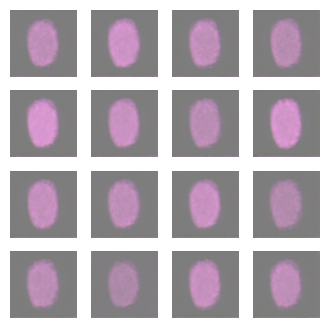

📉 FID Score: 380.7106
🏆 New best FID: 380.7106 at epoch 10
[baseline] Epoch 011 | Gen Loss: 8.3701 | Disc Loss: 0.0004
[baseline] Epoch 012 | Gen Loss: 7.5210 | Disc Loss: 0.0107
[baseline] Epoch 013 | Gen Loss: 9.0521 | Disc Loss: 1.3401
[baseline] Epoch 014 | Gen Loss: 4.8645 | Disc Loss: 0.4526
[baseline] Epoch 015 | Gen Loss: 10.8432 | Disc Loss: 0.0516
[baseline] Epoch 016 | Gen Loss: 2.3395 | Disc Loss: 3.3932
[baseline] Epoch 017 | Gen Loss: 3.5402 | Disc Loss: 0.3911
[baseline] Epoch 018 | Gen Loss: 1.9134 | Disc Loss: 1.9126
[baseline] Epoch 019 | Gen Loss: 2.1587 | Disc Loss: 1.0545
[baseline] Epoch 020 | Gen Loss: 2.9919 | Disc Loss: 0.5476


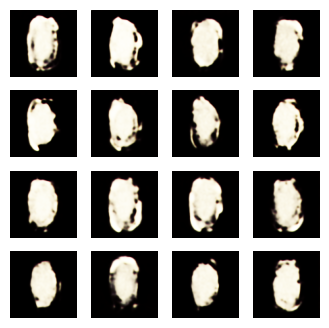

📉 FID Score: 325.6409
🏆 New best FID: 325.6409 at epoch 20
[baseline] Epoch 021 | Gen Loss: 2.5763 | Disc Loss: 0.7128
[baseline] Epoch 022 | Gen Loss: 1.8112 | Disc Loss: 1.1637
[baseline] Epoch 023 | Gen Loss: 1.5460 | Disc Loss: 1.3396
[baseline] Epoch 024 | Gen Loss: 2.0104 | Disc Loss: 0.6697
[baseline] Epoch 025 | Gen Loss: 1.6455 | Disc Loss: 1.0586
[baseline] Epoch 026 | Gen Loss: 1.6509 | Disc Loss: 0.8592
[baseline] Epoch 027 | Gen Loss: 1.7418 | Disc Loss: 0.7529
[baseline] Epoch 028 | Gen Loss: 1.7060 | Disc Loss: 0.6111
[baseline] Epoch 029 | Gen Loss: 1.7111 | Disc Loss: 0.7062
[baseline] Epoch 030 | Gen Loss: 2.1924 | Disc Loss: 0.5136


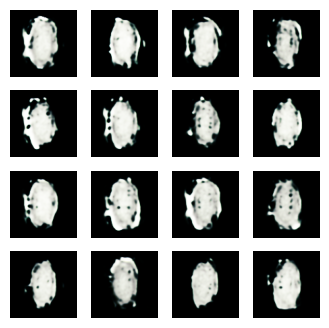

📉 FID Score: 326.2013
[baseline] Epoch 031 | Gen Loss: 2.4046 | Disc Loss: 0.4234
[baseline] Epoch 032 | Gen Loss: 1.9203 | Disc Loss: 0.7384
[baseline] Epoch 033 | Gen Loss: 2.5230 | Disc Loss: 0.4465
[baseline] Epoch 034 | Gen Loss: 2.1715 | Disc Loss: 0.5749
[baseline] Epoch 035 | Gen Loss: 2.4538 | Disc Loss: 0.3924
[baseline] Epoch 036 | Gen Loss: 1.6755 | Disc Loss: 0.7903
[baseline] Epoch 037 | Gen Loss: 1.7609 | Disc Loss: 0.8314
[baseline] Epoch 038 | Gen Loss: 2.1279 | Disc Loss: 0.4597
[baseline] Epoch 039 | Gen Loss: 1.6294 | Disc Loss: 0.7609
[baseline] Epoch 040 | Gen Loss: 2.0041 | Disc Loss: 0.6949


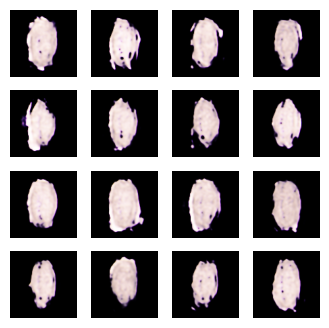

📉 FID Score: 293.7974
🏆 New best FID: 293.7974 at epoch 40
[baseline] Epoch 041 | Gen Loss: 2.3112 | Disc Loss: 0.5906
[baseline] Epoch 042 | Gen Loss: 1.7527 | Disc Loss: 0.6426
[baseline] Epoch 043 | Gen Loss: 1.3372 | Disc Loss: 0.9068
[baseline] Epoch 044 | Gen Loss: 1.4783 | Disc Loss: 0.7508
[baseline] Epoch 045 | Gen Loss: 1.4713 | Disc Loss: 0.7058
[baseline] Epoch 046 | Gen Loss: 1.7689 | Disc Loss: 0.5983
[baseline] Epoch 047 | Gen Loss: 1.3763 | Disc Loss: 0.9823
[baseline] Epoch 048 | Gen Loss: 1.6001 | Disc Loss: 0.6983
[baseline] Epoch 049 | Gen Loss: 1.6734 | Disc Loss: 0.6806
[baseline] Epoch 050 | Gen Loss: 1.2671 | Disc Loss: 0.9439


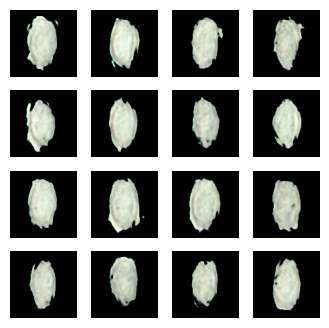

📉 FID Score: 271.8677
🏆 New best FID: 271.8677 at epoch 50
[baseline] Epoch 051 | Gen Loss: 1.5183 | Disc Loss: 0.7682
[baseline] Epoch 052 | Gen Loss: 1.6218 | Disc Loss: 0.7118
[baseline] Epoch 053 | Gen Loss: 1.7595 | Disc Loss: 0.7473
[baseline] Epoch 054 | Gen Loss: 1.5675 | Disc Loss: 1.1258
[baseline] Epoch 055 | Gen Loss: 1.7637 | Disc Loss: 0.7945
[baseline] Epoch 056 | Gen Loss: 1.4062 | Disc Loss: 0.7807
[baseline] Epoch 057 | Gen Loss: 1.1498 | Disc Loss: 1.1745
[baseline] Epoch 058 | Gen Loss: 1.5153 | Disc Loss: 0.7826
[baseline] Epoch 059 | Gen Loss: 1.6661 | Disc Loss: 0.6557
[baseline] Epoch 060 | Gen Loss: 1.1685 | Disc Loss: 1.2452


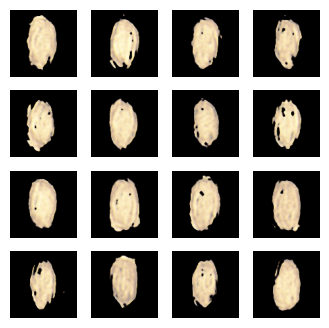

📉 FID Score: 320.7953
[baseline] Epoch 061 | Gen Loss: 2.0281 | Disc Loss: 0.4392
[baseline] Epoch 062 | Gen Loss: 1.1702 | Disc Loss: 1.0005
[baseline] Epoch 063 | Gen Loss: 1.5210 | Disc Loss: 0.6290
[baseline] Epoch 064 | Gen Loss: 1.2124 | Disc Loss: 0.9240
[baseline] Epoch 065 | Gen Loss: 1.3386 | Disc Loss: 0.8269
[baseline] Epoch 066 | Gen Loss: 1.4937 | Disc Loss: 0.7159
[baseline] Epoch 067 | Gen Loss: 1.3404 | Disc Loss: 0.9258
[baseline] Epoch 068 | Gen Loss: 1.6516 | Disc Loss: 0.6327
[baseline] Epoch 069 | Gen Loss: 1.2317 | Disc Loss: 1.0491
[baseline] Epoch 070 | Gen Loss: 1.3413 | Disc Loss: 0.8846


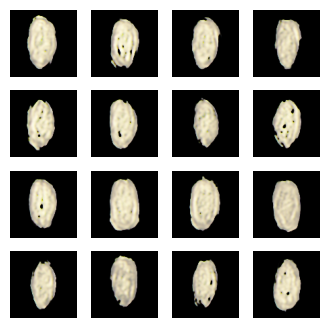

📉 FID Score: 270.1968
🏆 New best FID: 270.1968 at epoch 70
[baseline] Epoch 071 | Gen Loss: 1.4799 | Disc Loss: 0.8294
[baseline] Epoch 072 | Gen Loss: 1.2375 | Disc Loss: 0.9838
[baseline] Epoch 073 | Gen Loss: 1.2912 | Disc Loss: 0.9173
[baseline] Epoch 074 | Gen Loss: 1.4709 | Disc Loss: 0.7081
[baseline] Epoch 075 | Gen Loss: 1.4401 | Disc Loss: 0.9335
[baseline] Epoch 076 | Gen Loss: 1.6133 | Disc Loss: 0.6694
[baseline] Epoch 077 | Gen Loss: 1.4469 | Disc Loss: 0.8028
[baseline] Epoch 078 | Gen Loss: 1.1722 | Disc Loss: 0.9476
[baseline] Epoch 079 | Gen Loss: 1.4001 | Disc Loss: 0.7714
[baseline] Epoch 080 | Gen Loss: 1.4904 | Disc Loss: 0.8315


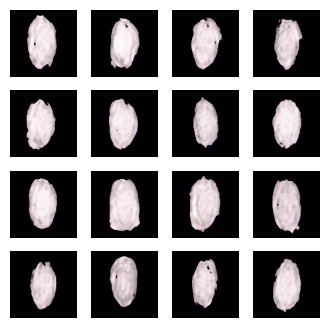

📉 FID Score: 271.7510
[baseline] Epoch 081 | Gen Loss: 1.8626 | Disc Loss: 0.5826
[baseline] Epoch 082 | Gen Loss: 1.6227 | Disc Loss: 0.8351
[baseline] Epoch 083 | Gen Loss: 1.6940 | Disc Loss: 0.8007
[baseline] Epoch 084 | Gen Loss: 1.8262 | Disc Loss: 0.6575
[baseline] Epoch 085 | Gen Loss: 1.1719 | Disc Loss: 1.0414
[baseline] Epoch 086 | Gen Loss: 1.4638 | Disc Loss: 0.8671
[baseline] Epoch 087 | Gen Loss: 1.5540 | Disc Loss: 0.7457
[baseline] Epoch 088 | Gen Loss: 1.3530 | Disc Loss: 1.1190
[baseline] Epoch 089 | Gen Loss: 1.8024 | Disc Loss: 0.7674
[baseline] Epoch 090 | Gen Loss: 1.9876 | Disc Loss: 0.4695


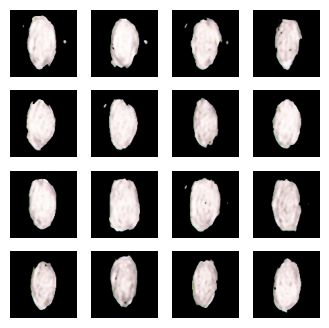

📉 FID Score: 275.8606
[baseline] Epoch 091 | Gen Loss: 1.4436 | Disc Loss: 0.9859
[baseline] Epoch 092 | Gen Loss: 1.1858 | Disc Loss: 1.0712
[baseline] Epoch 093 | Gen Loss: 1.5486 | Disc Loss: 0.6688
[baseline] Epoch 094 | Gen Loss: 1.4833 | Disc Loss: 0.7390
[baseline] Epoch 095 | Gen Loss: 1.2156 | Disc Loss: 1.0381
[baseline] Epoch 096 | Gen Loss: 1.5689 | Disc Loss: 0.7145
[baseline] Epoch 097 | Gen Loss: 1.7240 | Disc Loss: 0.6916
[baseline] Epoch 098 | Gen Loss: 1.4694 | Disc Loss: 0.8017
[baseline] Epoch 099 | Gen Loss: 1.1521 | Disc Loss: 0.9564
[baseline] Epoch 100 | Gen Loss: 1.6325 | Disc Loss: 0.5511


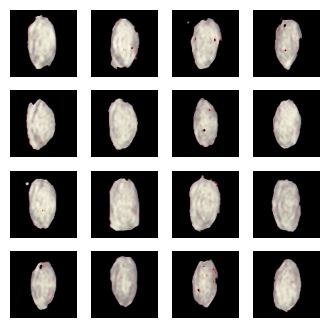

📉 FID Score: 257.3096
🏆 New best FID: 257.3096 at epoch 100
[baseline] Epoch 101 | Gen Loss: 2.0341 | Disc Loss: 0.8215
[baseline] Epoch 102 | Gen Loss: 1.6711 | Disc Loss: 0.9532
[baseline] Epoch 103 | Gen Loss: 1.3849 | Disc Loss: 1.0332
[baseline] Epoch 104 | Gen Loss: 1.5015 | Disc Loss: 0.7257
[baseline] Epoch 105 | Gen Loss: 1.1227 | Disc Loss: 1.2042
[baseline] Epoch 106 | Gen Loss: 1.7051 | Disc Loss: 0.5463
[baseline] Epoch 107 | Gen Loss: 1.2508 | Disc Loss: 0.8829
[baseline] Epoch 108 | Gen Loss: 1.4620 | Disc Loss: 0.7084
[baseline] Epoch 109 | Gen Loss: 1.4162 | Disc Loss: 0.7787
[baseline] Epoch 110 | Gen Loss: 1.2736 | Disc Loss: 0.9286


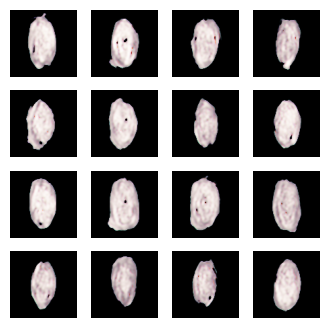

📉 FID Score: 265.8196
[baseline] Epoch 111 | Gen Loss: 1.3335 | Disc Loss: 0.9009
[baseline] Epoch 112 | Gen Loss: 1.4470 | Disc Loss: 0.8162
[baseline] Epoch 113 | Gen Loss: 1.6268 | Disc Loss: 0.7634
[baseline] Epoch 114 | Gen Loss: 1.2951 | Disc Loss: 1.1088
[baseline] Epoch 115 | Gen Loss: 1.9939 | Disc Loss: 0.5186
[baseline] Epoch 116 | Gen Loss: 1.4966 | Disc Loss: 1.0165
[baseline] Epoch 117 | Gen Loss: 1.5162 | Disc Loss: 0.7729
[baseline] Epoch 118 | Gen Loss: 1.7060 | Disc Loss: 0.6515
[baseline] Epoch 119 | Gen Loss: 1.5683 | Disc Loss: 0.6084
[baseline] Epoch 120 | Gen Loss: 1.3489 | Disc Loss: 0.8510


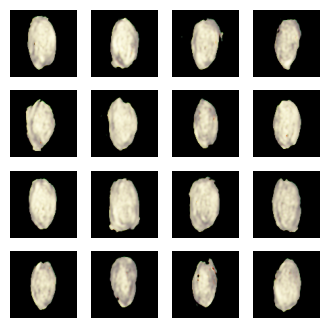

📉 FID Score: 243.8639
🏆 New best FID: 243.8639 at epoch 120
[baseline] Epoch 121 | Gen Loss: 1.4177 | Disc Loss: 0.8794
[baseline] Epoch 122 | Gen Loss: 1.4060 | Disc Loss: 0.9151
[baseline] Epoch 123 | Gen Loss: 1.9749 | Disc Loss: 0.5455
[baseline] Epoch 124 | Gen Loss: 2.1286 | Disc Loss: 0.4608
[baseline] Epoch 125 | Gen Loss: 1.6320 | Disc Loss: 0.6725
[baseline] Epoch 126 | Gen Loss: 1.5396 | Disc Loss: 0.8779
[baseline] Epoch 127 | Gen Loss: 1.8245 | Disc Loss: 0.6937
[baseline] Epoch 128 | Gen Loss: 1.7186 | Disc Loss: 0.5538
[baseline] Epoch 129 | Gen Loss: 1.2505 | Disc Loss: 0.8756
[baseline] Epoch 130 | Gen Loss: 1.4008 | Disc Loss: 0.7380


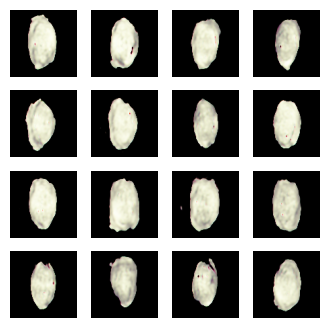

📉 FID Score: 247.5133
[baseline] Epoch 131 | Gen Loss: 1.4483 | Disc Loss: 0.7039
[baseline] Epoch 132 | Gen Loss: 1.3477 | Disc Loss: 0.8523
[baseline] Epoch 133 | Gen Loss: 1.2641 | Disc Loss: 0.8400
[baseline] Epoch 134 | Gen Loss: 1.2121 | Disc Loss: 0.9021
[baseline] Epoch 135 | Gen Loss: 1.4542 | Disc Loss: 0.7315
[baseline] Epoch 136 | Gen Loss: 1.2778 | Disc Loss: 1.0436
[baseline] Epoch 137 | Gen Loss: 1.8976 | Disc Loss: 0.7311
[baseline] Epoch 138 | Gen Loss: 1.4234 | Disc Loss: 1.2565
[baseline] Epoch 139 | Gen Loss: 1.7345 | Disc Loss: 0.9227
[baseline] Epoch 140 | Gen Loss: 1.6615 | Disc Loss: 1.4224


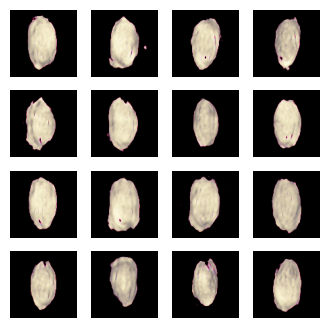

📉 FID Score: 252.4383
[baseline] Epoch 141 | Gen Loss: 1.4699 | Disc Loss: 1.0904
[baseline] Epoch 142 | Gen Loss: 1.3246 | Disc Loss: 0.9279
[baseline] Epoch 143 | Gen Loss: 1.3964 | Disc Loss: 0.8568
[baseline] Epoch 144 | Gen Loss: 1.2298 | Disc Loss: 1.0793
[baseline] Epoch 145 | Gen Loss: 1.4039 | Disc Loss: 0.9112
[baseline] Epoch 146 | Gen Loss: 1.1539 | Disc Loss: 1.2862
[baseline] Epoch 147 | Gen Loss: 2.0299 | Disc Loss: 0.6566
[baseline] Epoch 148 | Gen Loss: 1.2629 | Disc Loss: 1.1355
[baseline] Epoch 149 | Gen Loss: 1.4305 | Disc Loss: 0.8709
[baseline] Epoch 150 | Gen Loss: 1.1862 | Disc Loss: 1.0866


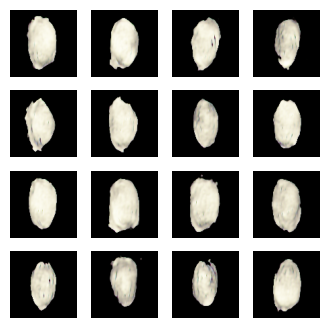

📉 FID Score: 256.9354
[baseline] Epoch 151 | Gen Loss: 1.1918 | Disc Loss: 0.9350
[baseline] Epoch 152 | Gen Loss: 1.1578 | Disc Loss: 0.9768
[baseline] Epoch 153 | Gen Loss: 1.2038 | Disc Loss: 0.8590
[baseline] Epoch 154 | Gen Loss: 1.1407 | Disc Loss: 0.9771
[baseline] Epoch 155 | Gen Loss: 1.1715 | Disc Loss: 1.1752
[baseline] Epoch 156 | Gen Loss: 1.6939 | Disc Loss: 0.7331
[baseline] Epoch 157 | Gen Loss: 1.1377 | Disc Loss: 1.3053
[baseline] Epoch 158 | Gen Loss: 1.4144 | Disc Loss: 0.8129
[baseline] Epoch 159 | Gen Loss: 1.1170 | Disc Loss: 1.0939
[baseline] Epoch 160 | Gen Loss: 1.1412 | Disc Loss: 0.9777


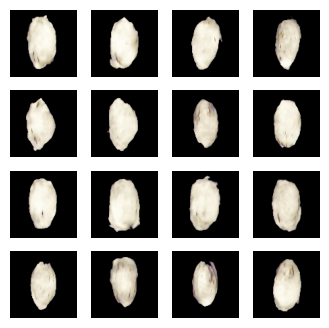

📉 FID Score: 249.6125
[baseline] Epoch 161 | Gen Loss: 1.2086 | Disc Loss: 0.9942
[baseline] Epoch 162 | Gen Loss: 1.1666 | Disc Loss: 0.9440
[baseline] Epoch 163 | Gen Loss: 1.1645 | Disc Loss: 0.9611
[baseline] Epoch 164 | Gen Loss: 1.1294 | Disc Loss: 0.9978
[baseline] Epoch 165 | Gen Loss: 1.1839 | Disc Loss: 0.9292
[baseline] Epoch 166 | Gen Loss: 1.0819 | Disc Loss: 1.1554
[baseline] Epoch 167 | Gen Loss: 1.3516 | Disc Loss: 0.8176
[baseline] Epoch 168 | Gen Loss: 1.0436 | Disc Loss: 1.1175
[baseline] Epoch 169 | Gen Loss: 1.2723 | Disc Loss: 0.8701
[baseline] Epoch 170 | Gen Loss: 1.1674 | Disc Loss: 1.0899


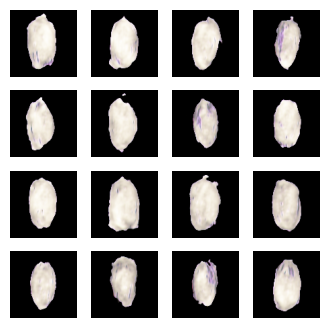

📉 FID Score: 233.5430
🏆 New best FID: 233.5430 at epoch 170
[baseline] Epoch 171 | Gen Loss: 1.3514 | Disc Loss: 0.8430
[baseline] Epoch 172 | Gen Loss: 1.1126 | Disc Loss: 1.0130
[baseline] Epoch 173 | Gen Loss: 1.0451 | Disc Loss: 1.0908
[baseline] Epoch 174 | Gen Loss: 1.1887 | Disc Loss: 0.9630
[baseline] Epoch 175 | Gen Loss: 1.0929 | Disc Loss: 1.1164
[baseline] Epoch 176 | Gen Loss: 1.2498 | Disc Loss: 0.8825
[baseline] Epoch 177 | Gen Loss: 1.1589 | Disc Loss: 0.9658
[baseline] Epoch 178 | Gen Loss: 1.1899 | Disc Loss: 0.8804
[baseline] Epoch 179 | Gen Loss: 1.1805 | Disc Loss: 0.9055
[baseline] Epoch 180 | Gen Loss: 1.2405 | Disc Loss: 0.8784


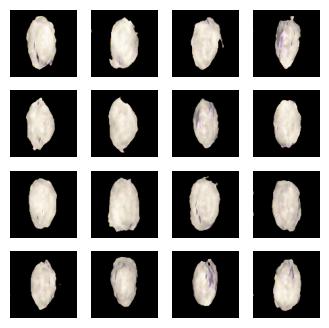

📉 FID Score: 254.2211
[baseline] Epoch 181 | Gen Loss: 1.2732 | Disc Loss: 0.8571
[baseline] Epoch 182 | Gen Loss: 1.1704 | Disc Loss: 1.2171
[baseline] Epoch 183 | Gen Loss: 1.8087 | Disc Loss: 0.9292
[baseline] Epoch 184 | Gen Loss: 1.7438 | Disc Loss: 1.3005
[baseline] Epoch 185 | Gen Loss: 1.1557 | Disc Loss: 1.0773
[baseline] Epoch 186 | Gen Loss: 1.1446 | Disc Loss: 1.0343
[baseline] Epoch 187 | Gen Loss: 1.3281 | Disc Loss: 0.8337
[baseline] Epoch 188 | Gen Loss: 1.2876 | Disc Loss: 0.8973
[baseline] Epoch 189 | Gen Loss: 1.3193 | Disc Loss: 0.8618
[baseline] Epoch 190 | Gen Loss: 1.3020 | Disc Loss: 0.9805


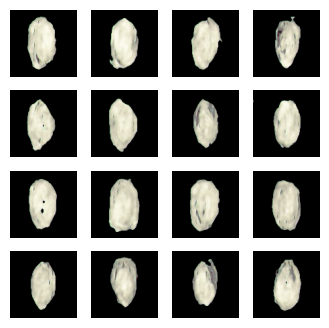

📉 FID Score: 268.8876
[baseline] Epoch 191 | Gen Loss: 1.2872 | Disc Loss: 0.8974
[baseline] Epoch 192 | Gen Loss: 1.2595 | Disc Loss: 0.9880
[baseline] Epoch 193 | Gen Loss: 1.3572 | Disc Loss: 0.9006
[baseline] Epoch 194 | Gen Loss: 1.1976 | Disc Loss: 0.9477
[baseline] Epoch 195 | Gen Loss: 0.9249 | Disc Loss: 1.2409
[baseline] Epoch 196 | Gen Loss: 1.4376 | Disc Loss: 0.7077
[baseline] Epoch 197 | Gen Loss: 0.9771 | Disc Loss: 1.3981
[baseline] Epoch 198 | Gen Loss: 1.3560 | Disc Loss: 0.8082
[baseline] Epoch 199 | Gen Loss: 1.1247 | Disc Loss: 0.9524
[baseline] Epoch 200 | Gen Loss: 1.2735 | Disc Loss: 0.9107


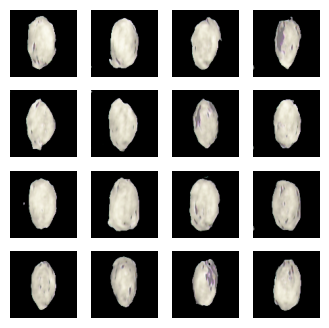

📉 FID Score: 257.9463


In [15]:
g_loss_base, d_loss_base, disc_acc_base, fid_scores_base = train_gan(generator_baseline, discriminator_baseline, train_dataset, EPOCHS, tag='baseline')

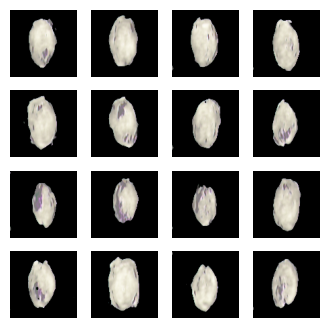

In [16]:
# show the best fid image generate
best_epoch = fid_scores_base.index(min(fid_scores_base)) + 1
test_input_best = tf.random.normal([16, NOISE_DIM]) # Generate new random noise for plotting
generate_and_save_images(generator_baseline, best_epoch, test_input_best, tag='baseline')

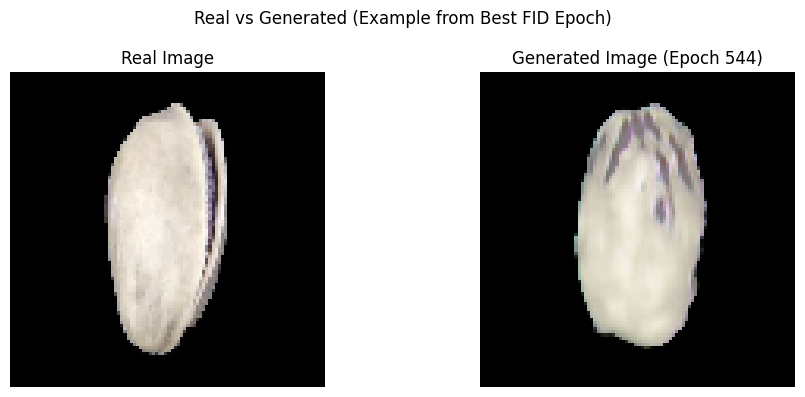

In [17]:
# Temukan epoch terbaik berdasarkan skor FID (baseline)
best_fid_index = fid_scores_base.index(min(fid_scores_base))
best_epoch = (best_fid_index + 1) * 32  # Jika kamu save FID setiap 32 epoch

# Generate satu gambar dari generator akhir dengan noise tetap
fixed_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator_baseline(fixed_noise, training=False).numpy()[0]

# Ambil real image dari batch pertama dataset
for real_batch in train_dataset.take(1):
    real_image = real_batch[0].numpy()  # Ambil satu real image
    break

# Denormalisasi jika data kamu disimpan di rentang [-1, 1]
real_image = (real_image + 1.0) / 2.0
generated_image = (generated_image + 1.0) / 2.0

# Plot
plt.figure(figsize=(10, 4))

# Real image kiri
plt.subplot(1, 2, 1)
plt.imshow(real_image)
plt.title('Real Image')
plt.axis('off')

# Generated image kanan
plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.title(f'Generated Image (Epoch {best_epoch})')
plt.axis('off')

plt.suptitle("Real vs Generated (Example from Best FID Epoch)")
plt.tight_layout()
plt.show()


In [ ]:
# **Baseline FID Plot**

Text(0, 0.5, 'FID')

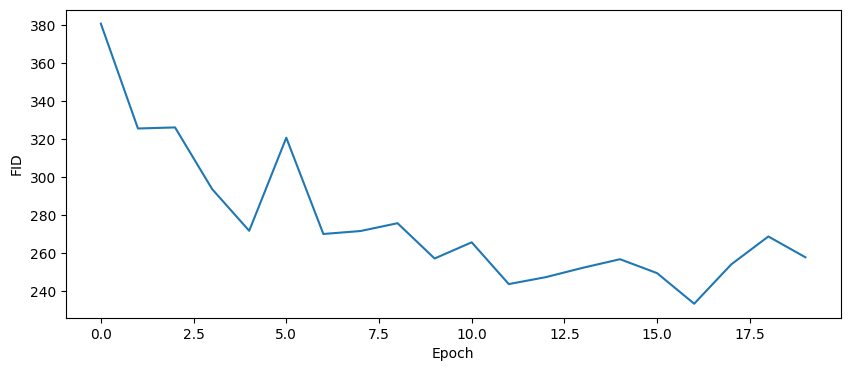

In [18]:
#plot fid
plt.figure(figsize=(10, 4))
plt.plot(fid_scores_base, label='FID Score - Baseline')
plt.xlabel('Epoch')
plt.ylabel('FID')

Plot menunjukkan **tren penurunan FID**, menandakan kualitas gambar makin membaik. Meski ada **fluktuasi**, model berhasil menghasilkan gambar yang lebih realistis seiring bertambahnya epoch.


# **Baseline Loss Plot**

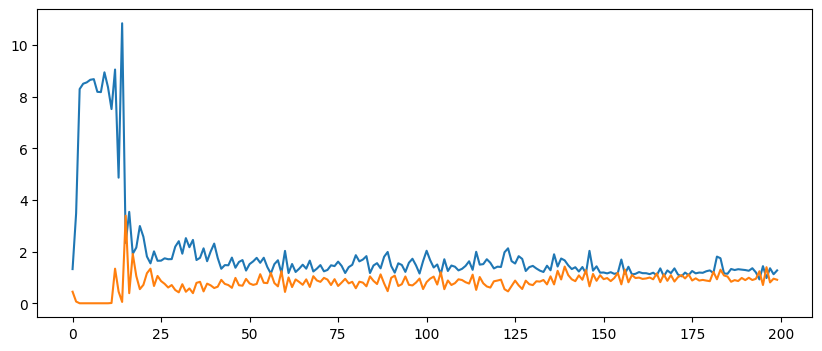

In [19]:
# plot loss
plt.figure(figsize=(10, 4))
plt.plot(g_loss_base, label='Generator Loss - Baseline')
plt.plot(d_loss_base, label='Discriminator Loss - Baseline')

Grafik kurva menunjukkan tanda **overfitting ringan**, ditandai *training loss* yang lebih rendah dari *validation loss*. Fluktuasi awal pada *validation loss* mengindikasikan ketidakstabilan di awal pelatihan, namun membaik seiring waktu saat model mulai menemukan pola yang lebih konsisten.


# **Bagian b : Modifikasi Model**

In [20]:
def build_generator_modif(NOISE_DIM=100):
    model = tf.keras.Sequential(name="Generator_Improved")
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(4 * 4 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, 5, strides=2, padding='same', activation='tanh'))
    model.add(layers.CenterCrop(100, 100))

    return model


In [21]:
def build_discriminator_modif():
    model = tf.keras.Sequential(name="Discriminator_Improved")
    model.add(layers.Input(shape=(100, 100, 3)))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,))

    return model


In [22]:
generator2 = build_generator_modif()
discriminator2 = build_discriminator_modif()

In [23]:
print("🧠 Arsitektur Generator:")
generator2.summary()

print("\n🧠 Arsitektur Discriminator:")
discriminator2.summary()

🧠 Arsitektur Generator:


Model: "Generator_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 16)     │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         1,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ center_crop (CenterCrop)        │ (None, 100, 100, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,124,467 (4.29 MB)

 Trainable params: 1,115,795 (4.26 MB)

 Non-trainable params: 8,672 (33.88 KB)


🧠 Arsitektur Discriminator:


Model: "Discriminator_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 50, 50, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 25, 25, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 13, 13, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 7, 7, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,781,889 (10.61 MB)

 Trainable params: 2,781,761 (10.61 MB)

 Non-trainable params: 128 (512.00 B)

| Komponen                       | Alasan Pemilihan                                                                                  |
| ------------------------------ | ------------------------------------------------------------------------------------------------- |
| **Conv2DTranspose**            | Untuk melakukan **upsampling bertahap** yang lebih halus dan natural dibandingkan resize biasa.   |
| **Reshape awal dari Dense**    | Memulai dari tensor kecil seperti `(4x4x256)` adalah pendekatan umum pada Deep Convolutional GAN. |
| **BatchNormalization**         | Menstabilkan distribusi layer selama training, **mencegah mode collapse**.                        |
| **LeakyReLU**                  | Menghindari dead neuron, membantu **training tetap aktif meski nilai input negatif**.             |
| **Dropout pada Discriminator** | Mencegah overfitting, membuat Discriminator tidak terlalu "kuat" terhadap Generator.              |
| **Deep Layer**                 | Layer lebih dalam memungkinkan model mempelajari **struktur spasial yang kompleks**.              |
| **CenterCrop akhir**           | Mengontrol **output final jadi 100x100**, menjaga konsistensi ukuran untuk perbandingan FID.      |


**Kelemahan Model Baseline yang Diatasi**
- **Terlalu sedikit layer** → Gambar kurang detail, mudah dibedakan Discriminator.
- **Tidak ada normalisasi** → Training GAN jadi tidak stabil.
- **Tidak ada dropout** → Discriminator terlalu mudah overfit.
- **Tidak ada Conv2DTranspose** → Tidak ada learned upsampling → hasil cenderung blur.

# **Function Generate Image**

In [24]:
def generate_and_save_images(model, epoch, test_input, tag):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 2))
    for i in range(predictions.shape[0]):
        plt.subplot(1, predictions.shape[0], i+1)
        plt.imshow((predictions[i] + 1) / 2)  # dari [-1,1] ke [0,1]
        plt.axis('off')
    plt.suptitle(f'{tag} - Epoch {epoch}')
    plt.show()


# **Function Train Modified**

In [25]:
def train_gan2(generator, discriminator, dataset, epochs, tag='modif'):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output):
        # Label smoothing untuk real
        real_labels = tf.ones_like(real_output) * 0.9
        real_loss = cross_entropy(real_labels, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    generator_optimizer = tf.keras.optimizers.Adam(1e-5)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

    g_loss_list, d_loss_list, fid_scores = [], [], []

    test_input = tf.random.normal([5, NOISE_DIM])
    fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    @tf.function
    def train_step(images):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            # Tambahkan noise kecil (instance noise) ke real & generated
            real_images_noisy = images + tf.random.normal(tf.shape(images), mean=0.0, stddev=0.05)
            generated_images_noisy = generated_images + tf.random.normal(tf.shape(generated_images), mean=0.0, stddev=0.05)

            real_output = discriminator(real_images_noisy, training=True)
            fake_output = discriminator(generated_images_noisy, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

        return gen_loss, disc_loss

    for epoch in range(1, epochs + 1):
        total_g_loss = 0
        total_d_loss = 0
        count = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            total_g_loss += g_loss
            total_d_loss += d_loss
            count += 1

        avg_g_loss = total_g_loss / count
        avg_d_loss = total_d_loss / count

        g_loss_list.append(avg_g_loss.numpy())
        d_loss_list.append(avg_d_loss.numpy())

        print(f"[Epoch {epoch}] Gen Loss: {avg_g_loss:.4f}, Disc Loss: {avg_d_loss:.4f}")

        if epoch % 50 == 0:
            generate_and_save_images(generator, epoch, test_input, tag)

            # Ambil 100 gambar real dan generate 100 gambar
            real_images_subset = next(iter(dataset.take(1)))[:100]
            noise = tf.random.normal([100, NOISE_DIM])
            generated_images = generator(noise, training=False)

            fid = calculate_fid(real_images_subset, generated_images)
            fid_scores.append(fid)
            print(f"FID @ Epoch {epoch}: {fid:.2f}")

            if fid < best_fid:
              best_fid = fid
              # Save the generator weights or the entire model if needed
              print(f"🏆 New best FID: {best_fid:.4f} at epoch {epoch}")

    return g_loss_list, d_loss_list, fid_scores


[Epoch 1] Gen Loss: 1.3388, Disc Loss: 0.8271
[Epoch 2] Gen Loss: 3.0972, Disc Loss: 0.3924
[Epoch 3] Gen Loss: 4.1076, Disc Loss: 0.3566
[Epoch 4] Gen Loss: 4.4920, Disc Loss: 0.3527
[Epoch 5] Gen Loss: 4.7288, Disc Loss: 0.3498
[Epoch 6] Gen Loss: 4.9453, Disc Loss: 0.3485
[Epoch 7] Gen Loss: 5.1184, Disc Loss: 0.3465
[Epoch 8] Gen Loss: 5.2254, Disc Loss: 0.3453
[Epoch 9] Gen Loss: 5.3999, Disc Loss: 0.3432
[Epoch 10] Gen Loss: 5.5588, Disc Loss: 0.3438
[Epoch 11] Gen Loss: 5.6307, Disc Loss: 0.3438
[Epoch 12] Gen Loss: 5.7736, Disc Loss: 0.3415
[Epoch 13] Gen Loss: 5.8389, Disc Loss: 0.3414
[Epoch 14] Gen Loss: 5.9044, Disc Loss: 0.3411
[Epoch 15] Gen Loss: 6.0039, Disc Loss: 0.3395
[Epoch 16] Gen Loss: 6.0478, Disc Loss: 0.3393
[Epoch 17] Gen Loss: 6.0948, Disc Loss: 0.3385
[Epoch 18] Gen Loss: 6.1063, Disc Loss: 0.3386
[Epoch 19] Gen Loss: 6.1243, Disc Loss: 0.3379
[Epoch 20] Gen Loss: 6.1240, Disc Loss: 0.3383
[Epoch 21] Gen Loss: 6.1293, Disc Loss: 0.3372
[Epoch 22] Gen Loss: 6

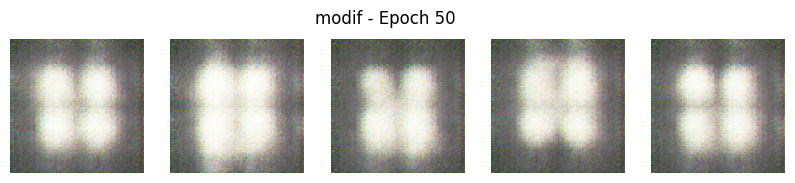

📉 FID Score: 113.1931
FID @ Epoch 50: 113.19
[Epoch 51] Gen Loss: 6.3456, Disc Loss: 0.3338
[Epoch 52] Gen Loss: 6.3626, Disc Loss: 0.3346
[Epoch 53] Gen Loss: 6.3355, Disc Loss: 0.3344
[Epoch 54] Gen Loss: 6.3682, Disc Loss: 0.3338
[Epoch 55] Gen Loss: 6.3578, Disc Loss: 0.3336
[Epoch 56] Gen Loss: 6.4008, Disc Loss: 0.3343
[Epoch 57] Gen Loss: 6.3221, Disc Loss: 0.3352
[Epoch 58] Gen Loss: 6.3038, Disc Loss: 0.3336
[Epoch 59] Gen Loss: 6.3614, Disc Loss: 0.3333
[Epoch 60] Gen Loss: 6.2971, Disc Loss: 0.3346
[Epoch 61] Gen Loss: 6.3526, Disc Loss: 0.3333
[Epoch 62] Gen Loss: 6.2690, Disc Loss: 0.3342
[Epoch 63] Gen Loss: 6.1820, Disc Loss: 0.3352
[Epoch 64] Gen Loss: 6.1873, Disc Loss: 0.3343
[Epoch 65] Gen Loss: 6.1234, Disc Loss: 0.3352
[Epoch 66] Gen Loss: 6.0374, Disc Loss: 0.3360
[Epoch 67] Gen Loss: 5.8407, Disc Loss: 0.3355
[Epoch 68] Gen Loss: 5.6502, Disc Loss: 0.3387
[Epoch 69] Gen Loss: 5.3912, Disc Loss: 0.3427
[Epoch 70] Gen Loss: 5.3817, Disc Loss: 0.3394
[Epoch 71] Gen 

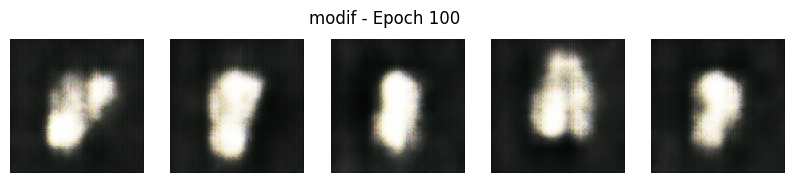

📉 FID Score: 112.9720
FID @ Epoch 100: 112.97
[Epoch 101] Gen Loss: 5.0257, Disc Loss: 0.3531
[Epoch 102] Gen Loss: 4.9967, Disc Loss: 0.3547
[Epoch 103] Gen Loss: 4.9412, Disc Loss: 0.3568
[Epoch 104] Gen Loss: 4.9455, Disc Loss: 0.3572
[Epoch 105] Gen Loss: 4.9500, Disc Loss: 0.3567
[Epoch 106] Gen Loss: 4.9270, Disc Loss: 0.3596
[Epoch 107] Gen Loss: 4.9443, Disc Loss: 0.3653
[Epoch 108] Gen Loss: 4.8857, Disc Loss: 0.3600
[Epoch 109] Gen Loss: 4.8566, Disc Loss: 0.3612
[Epoch 110] Gen Loss: 4.8940, Disc Loss: 0.3628
[Epoch 111] Gen Loss: 4.9469, Disc Loss: 0.3621
[Epoch 112] Gen Loss: 4.7453, Disc Loss: 0.3660
[Epoch 113] Gen Loss: 4.6541, Disc Loss: 0.3717
[Epoch 114] Gen Loss: 4.5777, Disc Loss: 0.3678
[Epoch 115] Gen Loss: 4.7004, Disc Loss: 0.3708
[Epoch 116] Gen Loss: 4.7088, Disc Loss: 0.3691
[Epoch 117] Gen Loss: 4.8415, Disc Loss: 0.3711
[Epoch 118] Gen Loss: 4.8903, Disc Loss: 0.3664
[Epoch 119] Gen Loss: 4.7510, Disc Loss: 0.3743
[Epoch 120] Gen Loss: 4.7023, Disc Loss: 0

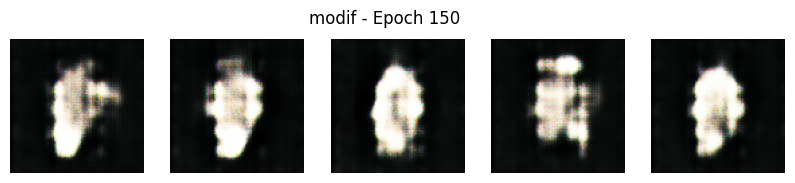

📉 FID Score: 109.6156
FID @ Epoch 150: 109.62
[Epoch 151] Gen Loss: 4.6462, Disc Loss: 0.3837
[Epoch 152] Gen Loss: 4.7296, Disc Loss: 0.3826
[Epoch 153] Gen Loss: 4.6494, Disc Loss: 0.3867
[Epoch 154] Gen Loss: 4.5776, Disc Loss: 0.3918
[Epoch 155] Gen Loss: 4.5302, Disc Loss: 0.3894
[Epoch 156] Gen Loss: 4.4486, Disc Loss: 0.3940
[Epoch 157] Gen Loss: 4.4067, Disc Loss: 0.3938
[Epoch 158] Gen Loss: 4.3472, Disc Loss: 0.3932
[Epoch 159] Gen Loss: 4.4561, Disc Loss: 0.3917
[Epoch 160] Gen Loss: 4.4833, Disc Loss: 0.3881
[Epoch 161] Gen Loss: 4.5357, Disc Loss: 0.3936
[Epoch 162] Gen Loss: 4.4703, Disc Loss: 0.3922
[Epoch 163] Gen Loss: 4.5102, Disc Loss: 0.4009
[Epoch 164] Gen Loss: 4.4352, Disc Loss: 0.3877
[Epoch 165] Gen Loss: 4.4839, Disc Loss: 0.3886
[Epoch 166] Gen Loss: 4.3814, Disc Loss: 0.4054
[Epoch 167] Gen Loss: 4.5373, Disc Loss: 0.3907
[Epoch 168] Gen Loss: 4.4754, Disc Loss: 0.3895
[Epoch 169] Gen Loss: 4.5089, Disc Loss: 0.3922
[Epoch 170] Gen Loss: 4.6336, Disc Loss: 0

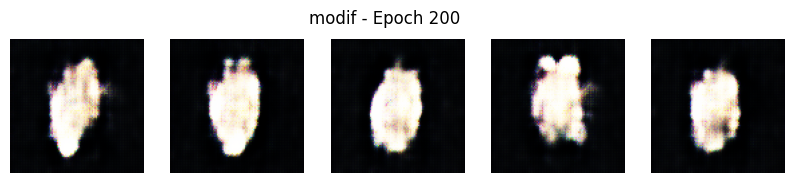

📉 FID Score: 77.1053
FID @ Epoch 200: 77.11
[Epoch 201] Gen Loss: 4.2274, Disc Loss: 0.4012
[Epoch 202] Gen Loss: 4.0887, Disc Loss: 0.4068
[Epoch 203] Gen Loss: 3.9817, Disc Loss: 0.4199
[Epoch 204] Gen Loss: 4.1066, Disc Loss: 0.4189
[Epoch 205] Gen Loss: 4.3498, Disc Loss: 0.4020
[Epoch 206] Gen Loss: 4.5427, Disc Loss: 0.4028
[Epoch 207] Gen Loss: 4.5399, Disc Loss: 0.3961
[Epoch 208] Gen Loss: 4.5289, Disc Loss: 0.3967
[Epoch 209] Gen Loss: 4.4705, Disc Loss: 0.3987
[Epoch 210] Gen Loss: 4.2539, Disc Loss: 0.4040
[Epoch 211] Gen Loss: 4.0992, Disc Loss: 0.4133
[Epoch 212] Gen Loss: 4.0069, Disc Loss: 0.4266
[Epoch 213] Gen Loss: 4.1340, Disc Loss: 0.4377
[Epoch 214] Gen Loss: 4.1707, Disc Loss: 0.4192
[Epoch 215] Gen Loss: 4.3241, Disc Loss: 0.4048
[Epoch 216] Gen Loss: 4.4531, Disc Loss: 0.3995
[Epoch 217] Gen Loss: 4.5209, Disc Loss: 0.4064
[Epoch 218] Gen Loss: 4.5845, Disc Loss: 0.3914
[Epoch 219] Gen Loss: 4.4803, Disc Loss: 0.4010
[Epoch 220] Gen Loss: 4.2827, Disc Loss: 0.4

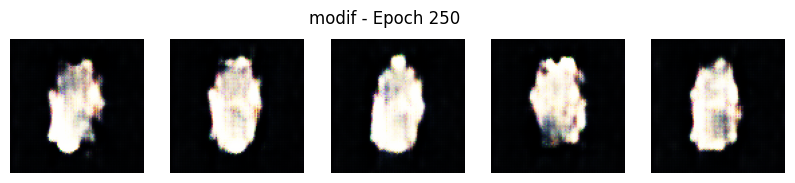

📉 FID Score: 66.8291
FID @ Epoch 250: 66.83
[Epoch 251] Gen Loss: 3.7214, Disc Loss: 0.4410
[Epoch 252] Gen Loss: 3.8760, Disc Loss: 0.4320
[Epoch 253] Gen Loss: 4.0848, Disc Loss: 0.4236
[Epoch 254] Gen Loss: 4.1518, Disc Loss: 0.4217
[Epoch 255] Gen Loss: 3.9789, Disc Loss: 0.4293
[Epoch 256] Gen Loss: 3.9820, Disc Loss: 0.4307
[Epoch 257] Gen Loss: 4.1629, Disc Loss: 0.4298
[Epoch 258] Gen Loss: 4.2160, Disc Loss: 0.4248
[Epoch 259] Gen Loss: 3.9542, Disc Loss: 0.4391
[Epoch 260] Gen Loss: 4.0287, Disc Loss: 0.4387
[Epoch 261] Gen Loss: 4.0916, Disc Loss: 0.4455
[Epoch 262] Gen Loss: 4.3616, Disc Loss: 0.4211
[Epoch 263] Gen Loss: 4.3787, Disc Loss: 0.4196
[Epoch 264] Gen Loss: 4.2348, Disc Loss: 0.4343
[Epoch 265] Gen Loss: 4.2669, Disc Loss: 0.4135
[Epoch 266] Gen Loss: 4.0682, Disc Loss: 0.4245
[Epoch 267] Gen Loss: 3.7307, Disc Loss: 0.4422
[Epoch 268] Gen Loss: 3.6983, Disc Loss: 0.4545
[Epoch 269] Gen Loss: 3.8646, Disc Loss: 0.4407
[Epoch 270] Gen Loss: 3.7591, Disc Loss: 0.4

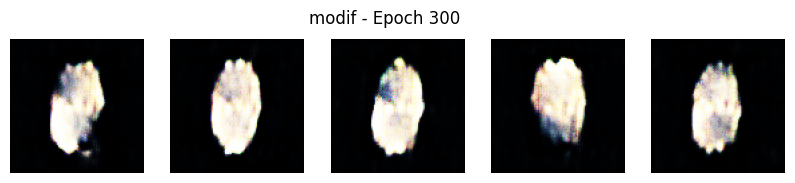

📉 FID Score: 33.6175
FID @ Epoch 300: 33.62
[Epoch 301] Gen Loss: 3.8344, Disc Loss: 0.4496
[Epoch 302] Gen Loss: 3.8494, Disc Loss: 0.4368
[Epoch 303] Gen Loss: 3.7691, Disc Loss: 0.4460
[Epoch 304] Gen Loss: 3.8226, Disc Loss: 0.4464
[Epoch 305] Gen Loss: 3.8221, Disc Loss: 0.4441
[Epoch 306] Gen Loss: 3.8852, Disc Loss: 0.4368
[Epoch 307] Gen Loss: 3.9421, Disc Loss: 0.4516
[Epoch 308] Gen Loss: 3.9983, Disc Loss: 0.4349
[Epoch 309] Gen Loss: 3.9823, Disc Loss: 0.4391
[Epoch 310] Gen Loss: 3.8030, Disc Loss: 0.4563
[Epoch 311] Gen Loss: 3.9800, Disc Loss: 0.4563
[Epoch 312] Gen Loss: 3.9376, Disc Loss: 0.4367
[Epoch 313] Gen Loss: 3.8201, Disc Loss: 0.4418
[Epoch 314] Gen Loss: 3.7515, Disc Loss: 0.4467
[Epoch 315] Gen Loss: 3.7279, Disc Loss: 0.4562
[Epoch 316] Gen Loss: 3.7367, Disc Loss: 0.4478
[Epoch 317] Gen Loss: 3.8060, Disc Loss: 0.4481
[Epoch 318] Gen Loss: 3.6342, Disc Loss: 0.4438
[Epoch 319] Gen Loss: 3.6426, Disc Loss: 0.4715
[Epoch 320] Gen Loss: 3.8275, Disc Loss: 0.4

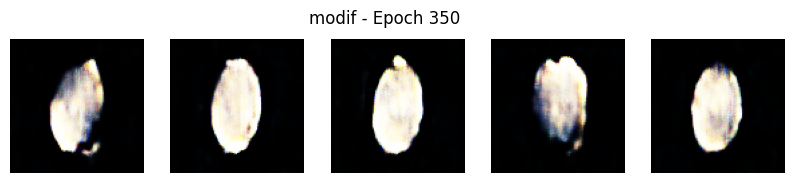

📉 FID Score: 18.7138
FID @ Epoch 350: 18.71
[Epoch 351] Gen Loss: 3.5832, Disc Loss: 0.4761
[Epoch 352] Gen Loss: 3.6184, Disc Loss: 0.4664
[Epoch 353] Gen Loss: 3.5831, Disc Loss: 0.4566
[Epoch 354] Gen Loss: 3.6012, Disc Loss: 0.4581
[Epoch 355] Gen Loss: 3.6009, Disc Loss: 0.4611
[Epoch 356] Gen Loss: 3.5683, Disc Loss: 0.4685
[Epoch 357] Gen Loss: 3.5252, Disc Loss: 0.4691
[Epoch 358] Gen Loss: 3.5179, Disc Loss: 0.4702
[Epoch 359] Gen Loss: 3.4915, Disc Loss: 0.4765
[Epoch 360] Gen Loss: 3.4725, Disc Loss: 0.4665
[Epoch 361] Gen Loss: 3.4867, Disc Loss: 0.4755
[Epoch 362] Gen Loss: 3.4661, Disc Loss: 0.4744
[Epoch 363] Gen Loss: 3.4772, Disc Loss: 0.4783
[Epoch 364] Gen Loss: 3.4720, Disc Loss: 0.4831
[Epoch 365] Gen Loss: 3.4720, Disc Loss: 0.4898
[Epoch 366] Gen Loss: 3.4589, Disc Loss: 0.4764
[Epoch 367] Gen Loss: 3.4646, Disc Loss: 0.4777
[Epoch 368] Gen Loss: 3.5319, Disc Loss: 0.4616
[Epoch 369] Gen Loss: 3.5031, Disc Loss: 0.4690
[Epoch 370] Gen Loss: 3.5099, Disc Loss: 0.4

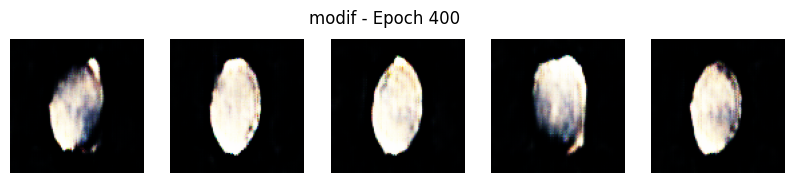

📉 FID Score: 17.6979
FID @ Epoch 400: 17.70
[Epoch 401] Gen Loss: 3.4705, Disc Loss: 0.4748
[Epoch 402] Gen Loss: 3.3538, Disc Loss: 0.4877
[Epoch 403] Gen Loss: 3.6426, Disc Loss: 0.4755
[Epoch 404] Gen Loss: 3.5209, Disc Loss: 0.4878
[Epoch 405] Gen Loss: 3.5700, Disc Loss: 0.4652
[Epoch 406] Gen Loss: 3.4466, Disc Loss: 0.4835
[Epoch 407] Gen Loss: 3.3600, Disc Loss: 0.4747
[Epoch 408] Gen Loss: 3.4821, Disc Loss: 0.4772
[Epoch 409] Gen Loss: 3.6868, Disc Loss: 0.4651
[Epoch 410] Gen Loss: 3.7119, Disc Loss: 0.4769
[Epoch 411] Gen Loss: 3.4542, Disc Loss: 0.5036
[Epoch 412] Gen Loss: 3.4733, Disc Loss: 0.4867
[Epoch 413] Gen Loss: 3.5705, Disc Loss: 0.4748
[Epoch 414] Gen Loss: 3.6012, Disc Loss: 0.4757
[Epoch 415] Gen Loss: 3.5898, Disc Loss: 0.4773
[Epoch 416] Gen Loss: 3.4345, Disc Loss: 0.4734
[Epoch 417] Gen Loss: 3.5659, Disc Loss: 0.4836
[Epoch 418] Gen Loss: 3.6047, Disc Loss: 0.4826
[Epoch 419] Gen Loss: 3.6216, Disc Loss: 0.4669
[Epoch 420] Gen Loss: 3.5168, Disc Loss: 0.4

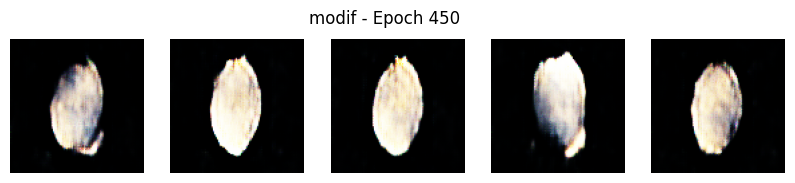

📉 FID Score: 22.1058
FID @ Epoch 450: 22.11
[Epoch 451] Gen Loss: 3.4364, Disc Loss: 0.4879
[Epoch 452] Gen Loss: 3.5586, Disc Loss: 0.4810
[Epoch 453] Gen Loss: 3.5423, Disc Loss: 0.4782
[Epoch 454] Gen Loss: 3.4847, Disc Loss: 0.4737
[Epoch 455] Gen Loss: 3.4661, Disc Loss: 0.4771
[Epoch 456] Gen Loss: 3.4677, Disc Loss: 0.4771
[Epoch 457] Gen Loss: 3.4770, Disc Loss: 0.4739
[Epoch 458] Gen Loss: 3.5291, Disc Loss: 0.4831
[Epoch 459] Gen Loss: 3.3432, Disc Loss: 0.4810
[Epoch 460] Gen Loss: 3.5134, Disc Loss: 0.4894
[Epoch 461] Gen Loss: 3.4333, Disc Loss: 0.4792
[Epoch 462] Gen Loss: 3.4621, Disc Loss: 0.4821
[Epoch 463] Gen Loss: 3.4570, Disc Loss: 0.4804
[Epoch 464] Gen Loss: 3.4786, Disc Loss: 0.4807
[Epoch 465] Gen Loss: 3.5168, Disc Loss: 0.4683
[Epoch 466] Gen Loss: 3.4731, Disc Loss: 0.4889
[Epoch 467] Gen Loss: 3.3945, Disc Loss: 0.4950
[Epoch 468] Gen Loss: 3.4556, Disc Loss: 0.4809
[Epoch 469] Gen Loss: 3.5541, Disc Loss: 0.4717
[Epoch 470] Gen Loss: 3.4875, Disc Loss: 0.4

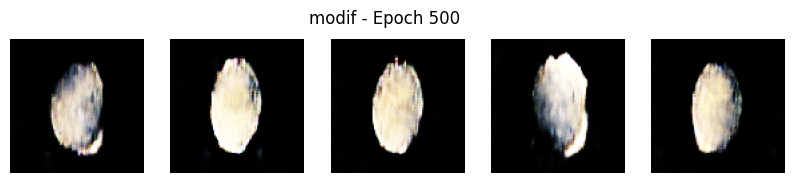

📉 FID Score: 22.9571
FID @ Epoch 500: 22.96
[Epoch 501] Gen Loss: 3.7222, Disc Loss: 0.4504
[Epoch 502] Gen Loss: 3.6354, Disc Loss: 0.4571
[Epoch 503] Gen Loss: 3.5765, Disc Loss: 0.4665
[Epoch 504] Gen Loss: 3.7631, Disc Loss: 0.4509
[Epoch 505] Gen Loss: 3.7099, Disc Loss: 0.4499
[Epoch 506] Gen Loss: 3.6412, Disc Loss: 0.4619
[Epoch 507] Gen Loss: 3.6493, Disc Loss: 0.4605
[Epoch 508] Gen Loss: 3.7506, Disc Loss: 0.4510
[Epoch 509] Gen Loss: 3.5904, Disc Loss: 0.4668
[Epoch 510] Gen Loss: 3.5066, Disc Loss: 0.4885
[Epoch 511] Gen Loss: 3.6873, Disc Loss: 0.4769
[Epoch 512] Gen Loss: 3.5889, Disc Loss: 0.4812
[Epoch 513] Gen Loss: 3.6218, Disc Loss: 0.4745
[Epoch 514] Gen Loss: 3.5583, Disc Loss: 0.4663
[Epoch 515] Gen Loss: 3.5252, Disc Loss: 0.4760
[Epoch 516] Gen Loss: 3.4871, Disc Loss: 0.4747
[Epoch 517] Gen Loss: 3.5128, Disc Loss: 0.4844
[Epoch 518] Gen Loss: 3.7012, Disc Loss: 0.4575
[Epoch 519] Gen Loss: 3.6860, Disc Loss: 0.4628
[Epoch 520] Gen Loss: 3.6819, Disc Loss: 0.4

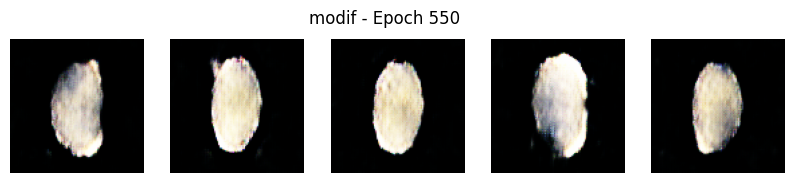

📉 FID Score: 20.3872
FID @ Epoch 550: 20.39
[Epoch 551] Gen Loss: 3.5578, Disc Loss: 0.4988
[Epoch 552] Gen Loss: 3.6059, Disc Loss: 0.4606
[Epoch 553] Gen Loss: 3.6868, Disc Loss: 0.4538
[Epoch 554] Gen Loss: 3.6326, Disc Loss: 0.4591
[Epoch 555] Gen Loss: 3.5559, Disc Loss: 0.4679
[Epoch 556] Gen Loss: 3.5843, Disc Loss: 0.4615
[Epoch 557] Gen Loss: 3.5327, Disc Loss: 0.4802
[Epoch 558] Gen Loss: 3.6788, Disc Loss: 0.4733
[Epoch 559] Gen Loss: 3.8055, Disc Loss: 0.4649
[Epoch 560] Gen Loss: 3.7340, Disc Loss: 0.4641
[Epoch 561] Gen Loss: 3.6612, Disc Loss: 0.4677
[Epoch 562] Gen Loss: 3.6644, Disc Loss: 0.4876
[Epoch 563] Gen Loss: 3.6676, Disc Loss: 0.4673
[Epoch 564] Gen Loss: 3.5841, Disc Loss: 0.4642
[Epoch 565] Gen Loss: 3.5174, Disc Loss: 0.4774
[Epoch 566] Gen Loss: 3.6731, Disc Loss: 0.4645
[Epoch 567] Gen Loss: 3.4987, Disc Loss: 0.4929
[Epoch 568] Gen Loss: 3.7403, Disc Loss: 0.4574
[Epoch 569] Gen Loss: 3.7870, Disc Loss: 0.4540
[Epoch 570] Gen Loss: 3.7480, Disc Loss: 0.4

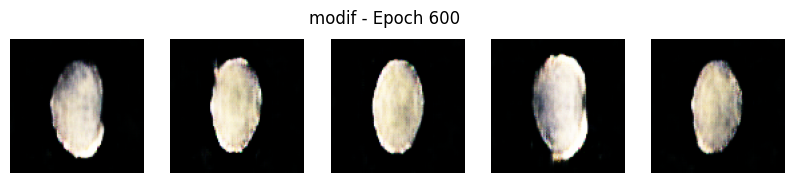

📉 FID Score: 16.5137
FID @ Epoch 600: 16.51
[Epoch 601] Gen Loss: 3.5522, Disc Loss: 0.4886
[Epoch 602] Gen Loss: 3.6775, Disc Loss: 0.4671
[Epoch 603] Gen Loss: 3.5929, Disc Loss: 0.4656
[Epoch 604] Gen Loss: 3.5433, Disc Loss: 0.4678
[Epoch 605] Gen Loss: 3.6440, Disc Loss: 0.4703
[Epoch 606] Gen Loss: 3.7435, Disc Loss: 0.4528
[Epoch 607] Gen Loss: 3.6656, Disc Loss: 0.4559
[Epoch 608] Gen Loss: 3.6061, Disc Loss: 0.4623
[Epoch 609] Gen Loss: 3.5258, Disc Loss: 0.4742
[Epoch 610] Gen Loss: 3.4789, Disc Loss: 0.4828
[Epoch 611] Gen Loss: 3.4531, Disc Loss: 0.4811
[Epoch 612] Gen Loss: 3.5097, Disc Loss: 0.4798
[Epoch 613] Gen Loss: 3.6147, Disc Loss: 0.4709
[Epoch 614] Gen Loss: 3.6988, Disc Loss: 0.4600
[Epoch 615] Gen Loss: 3.6353, Disc Loss: 0.4596
[Epoch 616] Gen Loss: 3.5429, Disc Loss: 0.4723
[Epoch 617] Gen Loss: 3.4911, Disc Loss: 0.4708
[Epoch 618] Gen Loss: 3.5975, Disc Loss: 0.4787
[Epoch 619] Gen Loss: 3.5025, Disc Loss: 0.4796
[Epoch 620] Gen Loss: 3.5569, Disc Loss: 0.4

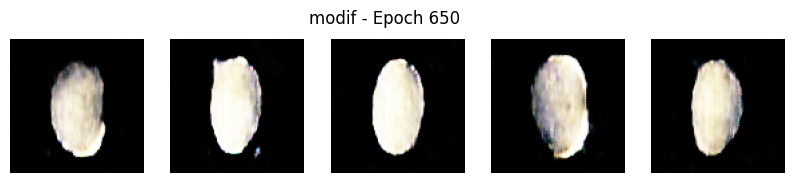

📉 FID Score: 14.7200
FID @ Epoch 650: 14.72
[Epoch 651] Gen Loss: 3.5066, Disc Loss: 0.4913
[Epoch 652] Gen Loss: 3.4646, Disc Loss: 0.4791
[Epoch 653] Gen Loss: 3.6470, Disc Loss: 0.4650
[Epoch 654] Gen Loss: 3.6610, Disc Loss: 0.4636
[Epoch 655] Gen Loss: 3.7203, Disc Loss: 0.4558
[Epoch 656] Gen Loss: 3.7012, Disc Loss: 0.4670
[Epoch 657] Gen Loss: 3.6830, Disc Loss: 0.4650
[Epoch 658] Gen Loss: 3.5654, Disc Loss: 0.4649
[Epoch 659] Gen Loss: 3.5550, Disc Loss: 0.4640
[Epoch 660] Gen Loss: 3.4882, Disc Loss: 0.4728
[Epoch 661] Gen Loss: 3.7566, Disc Loss: 0.4509
[Epoch 662] Gen Loss: 3.8975, Disc Loss: 0.4445
[Epoch 663] Gen Loss: 3.7399, Disc Loss: 0.4652
[Epoch 664] Gen Loss: 3.6618, Disc Loss: 0.4657
[Epoch 665] Gen Loss: 3.5864, Disc Loss: 0.4703
[Epoch 666] Gen Loss: 3.5120, Disc Loss: 0.4748
[Epoch 667] Gen Loss: 3.5748, Disc Loss: 0.4808
[Epoch 668] Gen Loss: 3.5905, Disc Loss: 0.4722
[Epoch 669] Gen Loss: 3.7464, Disc Loss: 0.4566
[Epoch 670] Gen Loss: 3.7599, Disc Loss: 0.4

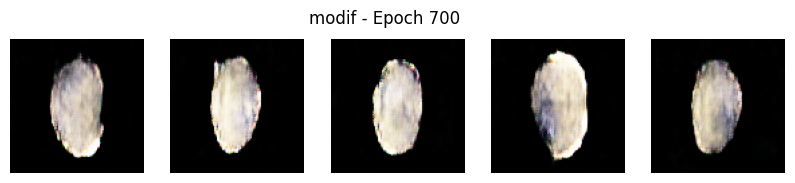

📉 FID Score: 16.2328
FID @ Epoch 700: 16.23
[Epoch 701] Gen Loss: 3.7498, Disc Loss: 0.4635
[Epoch 702] Gen Loss: 3.7093, Disc Loss: 0.4589
[Epoch 703] Gen Loss: 3.7878, Disc Loss: 0.4498
[Epoch 704] Gen Loss: 3.6361, Disc Loss: 0.4591
[Epoch 705] Gen Loss: 3.8103, Disc Loss: 0.4383
[Epoch 706] Gen Loss: 3.7824, Disc Loss: 0.4441
[Epoch 707] Gen Loss: 3.7405, Disc Loss: 0.4666
[Epoch 708] Gen Loss: 3.5590, Disc Loss: 0.4736
[Epoch 709] Gen Loss: 3.6829, Disc Loss: 0.4681
[Epoch 710] Gen Loss: 3.6366, Disc Loss: 0.4669
[Epoch 711] Gen Loss: 3.5044, Disc Loss: 0.4869
[Epoch 712] Gen Loss: 3.6077, Disc Loss: 0.4664
[Epoch 713] Gen Loss: 3.7320, Disc Loss: 0.4537
[Epoch 714] Gen Loss: 3.7076, Disc Loss: 0.4768
[Epoch 715] Gen Loss: 3.8619, Disc Loss: 0.4545
[Epoch 716] Gen Loss: 3.7284, Disc Loss: 0.4573
[Epoch 717] Gen Loss: 3.6144, Disc Loss: 0.4713
[Epoch 718] Gen Loss: 3.6701, Disc Loss: 0.4705
[Epoch 719] Gen Loss: 3.5581, Disc Loss: 0.4823
[Epoch 720] Gen Loss: 3.6428, Disc Loss: 0.4

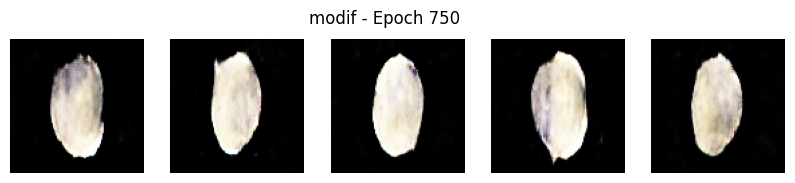

📉 FID Score: 15.7358
FID @ Epoch 750: 15.74
[Epoch 751] Gen Loss: 3.6779, Disc Loss: 0.4624
[Epoch 752] Gen Loss: 3.7386, Disc Loss: 0.4616
[Epoch 753] Gen Loss: 3.6251, Disc Loss: 0.4647
[Epoch 754] Gen Loss: 3.5494, Disc Loss: 0.4749
[Epoch 755] Gen Loss: 3.5115, Disc Loss: 0.4677
[Epoch 756] Gen Loss: 3.6191, Disc Loss: 0.4637
[Epoch 757] Gen Loss: 3.6252, Disc Loss: 0.4705
[Epoch 758] Gen Loss: 3.6862, Disc Loss: 0.4717
[Epoch 759] Gen Loss: 3.6250, Disc Loss: 0.4679
[Epoch 760] Gen Loss: 3.5820, Disc Loss: 0.4686
[Epoch 761] Gen Loss: 3.6160, Disc Loss: 0.4680
[Epoch 762] Gen Loss: 3.5572, Disc Loss: 0.4664
[Epoch 763] Gen Loss: 3.5988, Disc Loss: 0.4701
[Epoch 764] Gen Loss: 3.7068, Disc Loss: 0.4538
[Epoch 765] Gen Loss: 3.5582, Disc Loss: 0.4623
[Epoch 766] Gen Loss: 3.5803, Disc Loss: 0.4736
[Epoch 767] Gen Loss: 3.6475, Disc Loss: 0.4636
[Epoch 768] Gen Loss: 3.5913, Disc Loss: 0.4692
[Epoch 769] Gen Loss: 3.5647, Disc Loss: 0.4734
[Epoch 770] Gen Loss: 3.6017, Disc Loss: 0.4

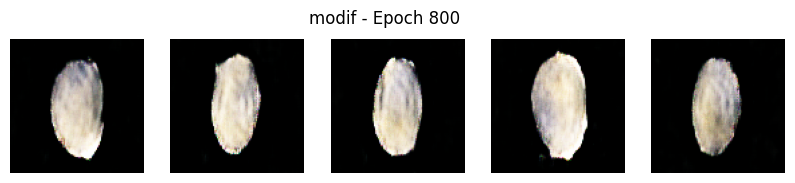

📉 FID Score: 13.8797
FID @ Epoch 800: 13.88
[Epoch 801] Gen Loss: 3.6703, Disc Loss: 0.4526
[Epoch 802] Gen Loss: 3.6643, Disc Loss: 0.4576
[Epoch 803] Gen Loss: 3.6640, Disc Loss: 0.4476
[Epoch 804] Gen Loss: 3.7255, Disc Loss: 0.4648
[Epoch 805] Gen Loss: 3.7188, Disc Loss: 0.4572
[Epoch 806] Gen Loss: 3.5994, Disc Loss: 0.4665
[Epoch 807] Gen Loss: 3.7006, Disc Loss: 0.4569
[Epoch 808] Gen Loss: 3.6640, Disc Loss: 0.4660
[Epoch 809] Gen Loss: 3.5970, Disc Loss: 0.4607
[Epoch 810] Gen Loss: 3.6007, Disc Loss: 0.4684
[Epoch 811] Gen Loss: 3.6421, Disc Loss: 0.4622
[Epoch 812] Gen Loss: 3.6026, Disc Loss: 0.4590
[Epoch 813] Gen Loss: 3.6108, Disc Loss: 0.4632
[Epoch 814] Gen Loss: 3.6446, Disc Loss: 0.4557
[Epoch 815] Gen Loss: 3.6378, Disc Loss: 0.4669
[Epoch 816] Gen Loss: 3.7273, Disc Loss: 0.4564
[Epoch 817] Gen Loss: 3.7018, Disc Loss: 0.4572
[Epoch 818] Gen Loss: 3.6144, Disc Loss: 0.4799
[Epoch 819] Gen Loss: 3.7171, Disc Loss: 0.4570
[Epoch 820] Gen Loss: 3.6791, Disc Loss: 0.4

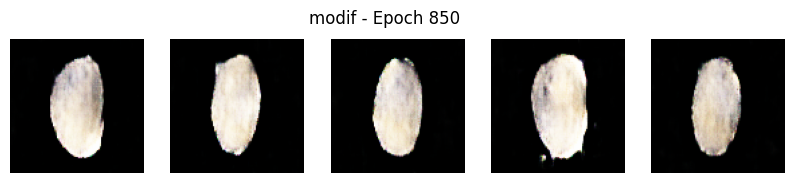

📉 FID Score: 16.4748
FID @ Epoch 850: 16.47
[Epoch 851] Gen Loss: 3.7497, Disc Loss: 0.4628
[Epoch 852] Gen Loss: 3.7679, Disc Loss: 0.4491
[Epoch 853] Gen Loss: 3.8909, Disc Loss: 0.4448
[Epoch 854] Gen Loss: 3.7944, Disc Loss: 0.4505
[Epoch 855] Gen Loss: 3.7068, Disc Loss: 0.4507
[Epoch 856] Gen Loss: 3.6408, Disc Loss: 0.4647
[Epoch 857] Gen Loss: 3.7051, Disc Loss: 0.4522
[Epoch 858] Gen Loss: 3.8241, Disc Loss: 0.4408
[Epoch 859] Gen Loss: 3.7961, Disc Loss: 0.4600
[Epoch 860] Gen Loss: 3.8433, Disc Loss: 0.4489
[Epoch 861] Gen Loss: 3.6938, Disc Loss: 0.4618
[Epoch 862] Gen Loss: 3.8880, Disc Loss: 0.4402
[Epoch 863] Gen Loss: 3.8432, Disc Loss: 0.4472
[Epoch 864] Gen Loss: 3.8799, Disc Loss: 0.4436
[Epoch 865] Gen Loss: 3.7729, Disc Loss: 0.4481
[Epoch 866] Gen Loss: 3.8892, Disc Loss: 0.4427
[Epoch 867] Gen Loss: 3.8703, Disc Loss: 0.4480
[Epoch 868] Gen Loss: 3.8358, Disc Loss: 0.4601
[Epoch 869] Gen Loss: 3.8436, Disc Loss: 0.4562
[Epoch 870] Gen Loss: 3.7746, Disc Loss: 0.4

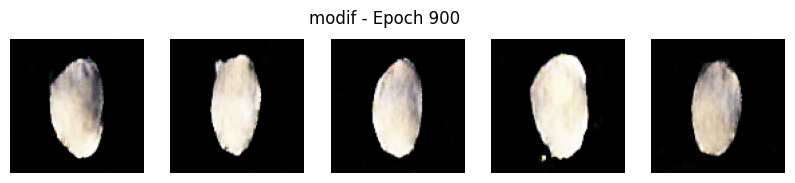

📉 FID Score: 16.6877
FID @ Epoch 900: 16.69
[Epoch 901] Gen Loss: 3.7942, Disc Loss: 0.4636
[Epoch 902] Gen Loss: 3.7511, Disc Loss: 0.4551
[Epoch 903] Gen Loss: 3.7543, Disc Loss: 0.4534
[Epoch 904] Gen Loss: 3.7607, Disc Loss: 0.4549
[Epoch 905] Gen Loss: 3.8343, Disc Loss: 0.4498
[Epoch 906] Gen Loss: 3.7576, Disc Loss: 0.4533
[Epoch 907] Gen Loss: 3.7927, Disc Loss: 0.4606
[Epoch 908] Gen Loss: 3.7310, Disc Loss: 0.4505
[Epoch 909] Gen Loss: 3.8162, Disc Loss: 0.4461
[Epoch 910] Gen Loss: 3.9137, Disc Loss: 0.4486
[Epoch 911] Gen Loss: 3.8863, Disc Loss: 0.4537
[Epoch 912] Gen Loss: 3.8537, Disc Loss: 0.4544
[Epoch 913] Gen Loss: 3.8299, Disc Loss: 0.4459
[Epoch 914] Gen Loss: 3.8699, Disc Loss: 0.4562
[Epoch 915] Gen Loss: 3.8840, Disc Loss: 0.4432
[Epoch 916] Gen Loss: 3.8714, Disc Loss: 0.4468
[Epoch 917] Gen Loss: 3.7676, Disc Loss: 0.4514
[Epoch 918] Gen Loss: 3.8262, Disc Loss: 0.4484
[Epoch 919] Gen Loss: 3.7413, Disc Loss: 0.4518
[Epoch 920] Gen Loss: 3.7696, Disc Loss: 0.4

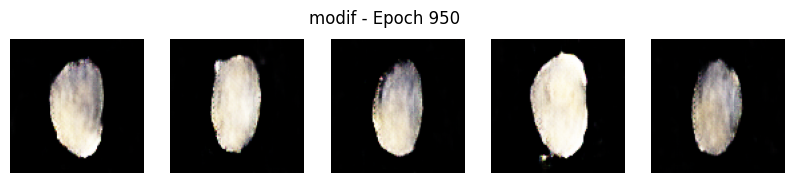

📉 FID Score: 14.8038
FID @ Epoch 950: 14.80
[Epoch 951] Gen Loss: 4.0758, Disc Loss: 0.4336
[Epoch 952] Gen Loss: 3.9002, Disc Loss: 0.4466
[Epoch 953] Gen Loss: 3.8397, Disc Loss: 0.4473
[Epoch 954] Gen Loss: 3.8121, Disc Loss: 0.4412
[Epoch 955] Gen Loss: 3.7345, Disc Loss: 0.4504
[Epoch 956] Gen Loss: 3.7466, Disc Loss: 0.4596
[Epoch 957] Gen Loss: 3.9940, Disc Loss: 0.4405
[Epoch 958] Gen Loss: 3.9514, Disc Loss: 0.4406
[Epoch 959] Gen Loss: 3.8272, Disc Loss: 0.4482
[Epoch 960] Gen Loss: 3.8729, Disc Loss: 0.4565
[Epoch 961] Gen Loss: 3.7528, Disc Loss: 0.4629
[Epoch 962] Gen Loss: 3.8066, Disc Loss: 0.4540
[Epoch 963] Gen Loss: 3.8065, Disc Loss: 0.4786
[Epoch 964] Gen Loss: 3.9351, Disc Loss: 0.4513
[Epoch 965] Gen Loss: 3.8350, Disc Loss: 0.4490
[Epoch 966] Gen Loss: 3.7883, Disc Loss: 0.4453
[Epoch 967] Gen Loss: 3.7913, Disc Loss: 0.4461
[Epoch 968] Gen Loss: 3.6209, Disc Loss: 0.4701
[Epoch 969] Gen Loss: 3.6787, Disc Loss: 0.4624
[Epoch 970] Gen Loss: 3.9339, Disc Loss: 0.4

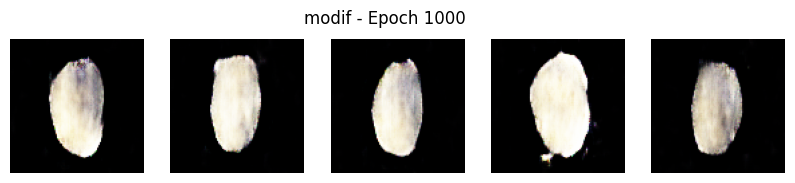

📉 FID Score: 12.1046
FID @ Epoch 1000: 12.10


In [26]:
EPOCHSS = 1000
g_loss_mod, d_loss_mod, fid_scores_mod = train_gan2(generator2, discriminator2, train_dataset, EPOCHSS, tag='modif')

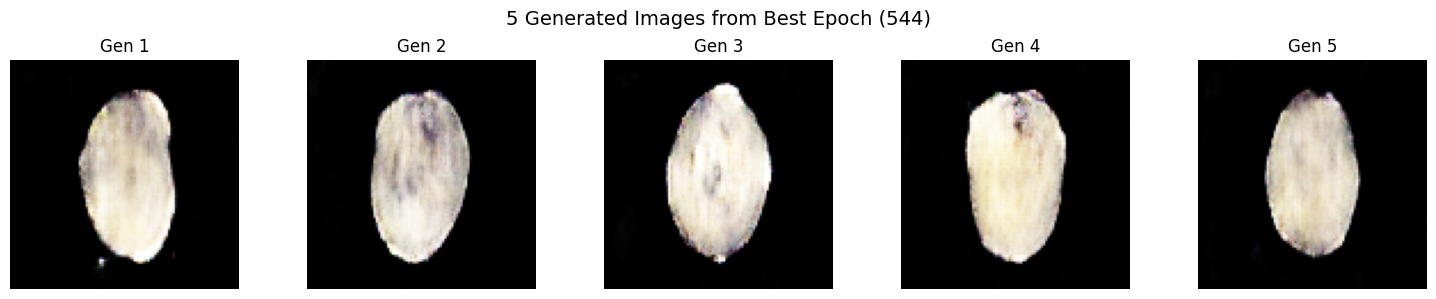

In [27]:
noise_5 = tf.random.normal([5, NOISE_DIM])
generated_images_5 = generator2(noise_5, training=False).numpy()
generated_images_5 = (generated_images_5 + 1.0) / 2.0

# 7. Tampilkan 5 generated images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_images_5[i])
    plt.title(f'Gen {i+1}')
    plt.axis('off')

plt.suptitle(f'5 Generated Images from Best Epoch ({best_epoch})', fontsize=14)
plt.tight_layout()
plt.show()


# **Compare Real Image with Best FID**

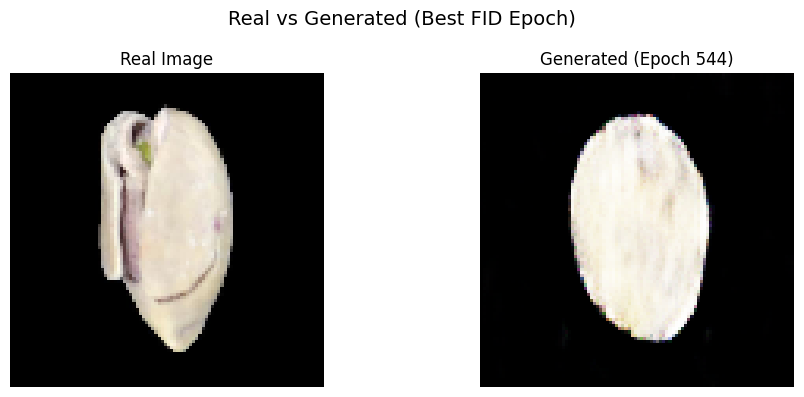

In [28]:
# 2. Ambil 1 real image dari dataset
for real_batch in train_dataset.take(1):
    real_image = real_batch[0].numpy()
    break

# 3. Generate 1 gambar untuk perbandingan
fixed_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator2(fixed_noise, training=False).numpy()[0]

# 4. Denormalisasi (jika dari Tanh)
real_image = (real_image + 1.0) / 2.0
generated_image = (generated_image + 1.0) / 2.0

# 5. Plot 1 real vs 1 generated image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(real_image)
plt.title('Real Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.title(f'Generated (Epoch {best_epoch})')
plt.axis('off')

plt.suptitle("Real vs Generated (Best FID Epoch)", fontsize=14)
plt.tight_layout()
plt.show()


# **Modified Loss Plot**

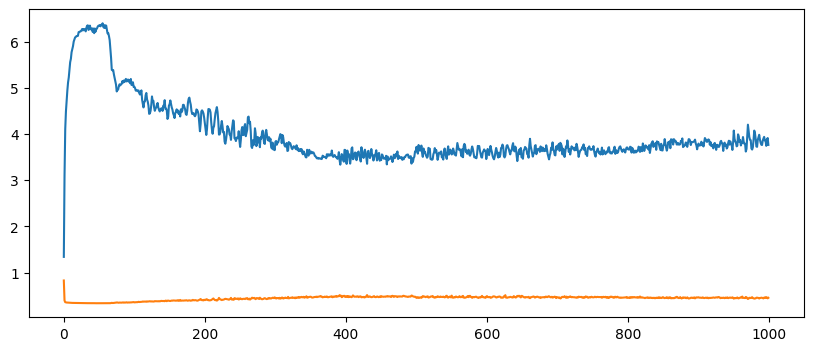

In [29]:
#plot g_loss_mod
plt.figure(figsize=(10, 4))
plt.plot(g_loss_mod, label='Generator Loss - Modified')
plt.plot(d_loss_mod, label='Discriminator Loss - Modified')


# **Overfitting - Data Terlalu Sedikit untuk GAN**

Grafik  menunjukkan bahwa model mengalami **overfitting**. Hal ini terlihat jelas dari adanya **celah (gap) yang sangat besar** antara garis *training loss* (oranye, bawah) yang sangat rendah dan garis *validation loss* (biru, atas) yang jauh lebih tinggi. Artinya, model Anda menjadi terlalu "pintar" dalam menghafal data latih, tetapi gagal menggeneralisasi polanya untuk data baru yang belum pernah dilihat. Akibatnya, performa model kemungkinan akan buruk saat digunakan untuk membuat prediksi di dunia nyata.

**Modified FID Plot**

Text(0, 0.5, 'FID')

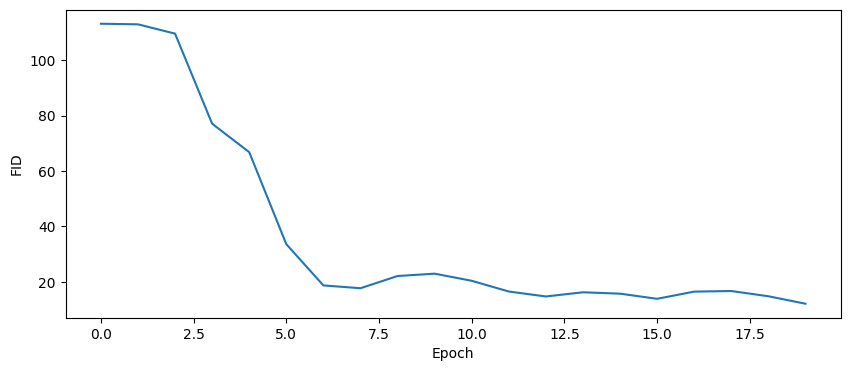

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(fid_scores_mod, label='FID Score - Modified')
plt.xlabel('Epoch')
plt.ylabel('FID')

Plot menunjukkan **tren penurunan FID**, menandakan kualitas gambar makin membaik. Meski ada **fluktuasi**, model berhasil menghasilkan gambar yang lebih realistis seiring bertambahnya epoch.


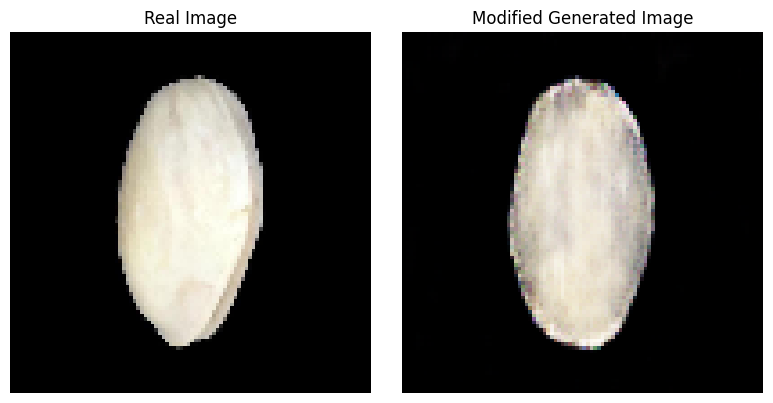

In [133]:
import random
if 'real_images' not in globals():
    print("Error: 'real_images' variable not found. Please run the data loading and preprocessing cells.")
else:
    random_index = random.randint(0, real_images.shape[0] - 1)
    real_image = real_images[random_index]
    real_image_display = (real_image + 1.0) / 2.0  # rescale back to [0, 1] for display

    if 'generator_baseline' not in globals():
         print("Error: 'generator_baseline' variable not found. Please run the baseline model training cell.")
    else:
        noise = tf.random.normal([1, NOISE_DIM])
        gen_base = generator2(noise, training=False).numpy()[0]

        # Rescale generated images
        gen_base_display = (gen_base + 1.0) / 2.0

        # Plot
        plt.figure(figsize=(8, 4))
        titles = ['Real Image', 'Modified Generated Image']
        images = [real_image_display, gen_base_display]
        for i in range(2): # Loop for 2 images
            plt.subplot(1, 2, i+1)
            plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

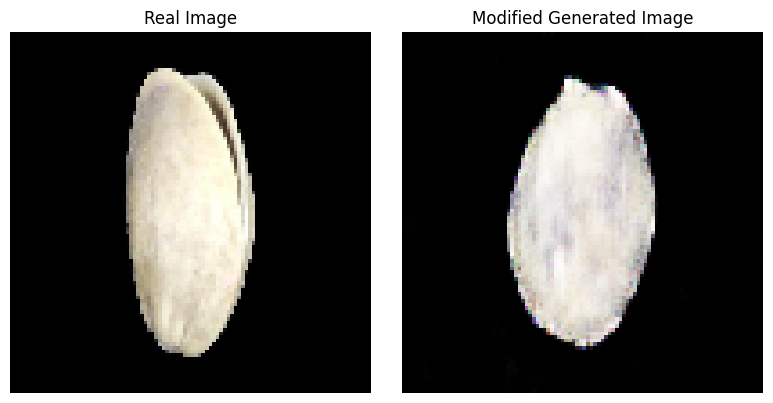

In [49]:
import random
if 'real_images' not in globals():
    print("Error: 'real_images' variable not found. Please run the data loading and preprocessing cells.")
else:
    random_index = random.randint(0, real_images.shape[0] - 1)
    real_image = real_images[random_index]
    real_image_display = (real_image + 1.0) / 2.0  # rescale back to [0, 1] for display

    if 'generator_baseline' not in globals():
         print("Error: 'generator_baseline' variable not found. Please run the baseline model training cell.")
    else:
        noise = tf.random.normal([1, NOISE_DIM])
        gen_base = generator2(noise, training=False).numpy()[0]

        # Rescale generated images
        gen_base_display = (gen_base + 1.0) / 2.0

        # Plot
        plt.figure(figsize=(8, 4))
        titles = ['Real Image', 'Modified Generated Image']
        images = [real_image_display, gen_base_display]
        for i in range(2): # Loop for 2 images
            plt.subplot(1, 2, i+1)
            plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

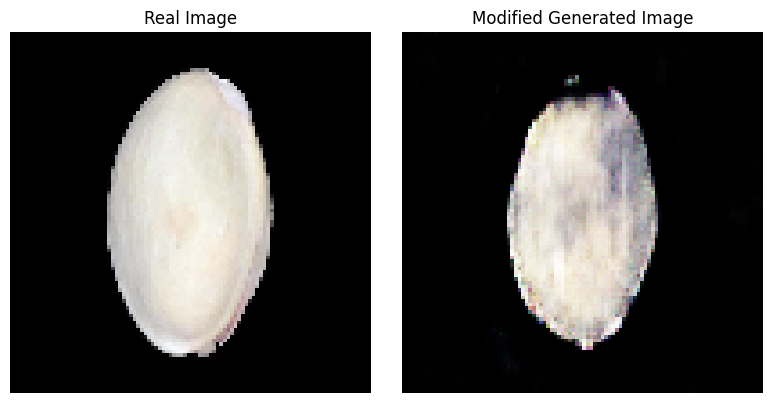

In [102]:
import random
if 'real_images' not in globals():
    print("Error: 'real_images' variable not found. Please run the data loading and preprocessing cells.")
else:
    random_index = random.randint(0, real_images.shape[0] - 1)
    real_image = real_images[random_index]
    real_image_display = (real_image + 1.0) / 2.0  # rescale back to [0, 1] for display

    if 'generator_baseline' not in globals():
         print("Error: 'generator_baseline' variable not found. Please run the baseline model training cell.")
    else:
        noise = tf.random.normal([1, NOISE_DIM])
        gen_base = generator2(noise, training=False).numpy()[0]

        # Rescale generated images
        gen_base_display = (gen_base + 1.0) / 2.0

        # Plot
        plt.figure(figsize=(8, 4))
        titles = ['Real Image', 'Modified Generated Image']
        images = [real_image_display, gen_base_display]
        for i in range(2): # Loop for 2 images
            plt.subplot(1, 2, i+1)
            plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# **Evaluation FID**

**BEST FID MODEL GAN MODIFIED**

In [36]:
best_fid_idx = np.argmin(fid_scores_mod)
best_epoch = (best_fid_idx + 1) * 50
print("=== Modified Model - Best FID Score ===")
print(f"Best FID: {fid_scores_mod[best_fid_idx]:.2f} at Epoch {best_epoch}")

Best FID: 12.10 at Epoch 1000


In [ ]:
best_fid_value = min(fid_scores_base)
best_fid_epoch = fid_scores_base.index(best_fid_value) * 10 # karena FID dihitung setiap 20 epoch
print("=== Baseline - Best FID Score ===")
print(f"Best FID Score: {best_fid_value:.4f} (at Epoch {best_fid_epoch})")


=== Modified Baseline - Best FID Score ===
Best FID Score: 233.5430 (at Epoch 160)


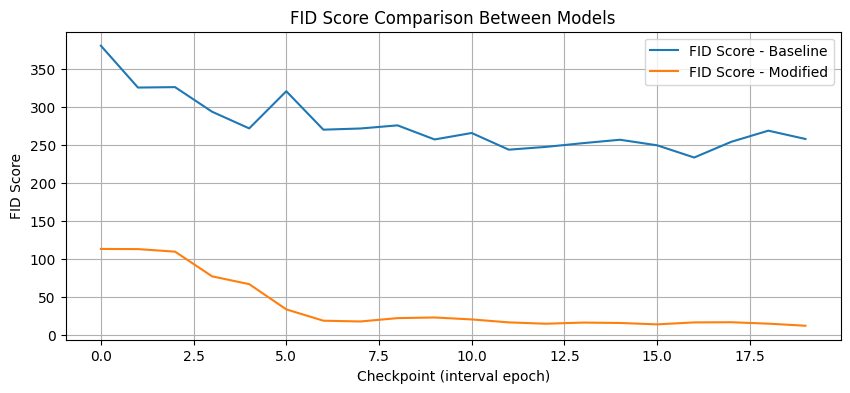

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(fid_scores_base, label='FID Score - Baseline')
plt.plot(fid_scores_mod, label='FID Score - Modified')
plt.xlabel('Checkpoint (interval epoch)')
plt.ylabel('FID Score')
plt.title('FID Score Comparison Between Models')
plt.legend()
plt.grid(True)
plt.show()


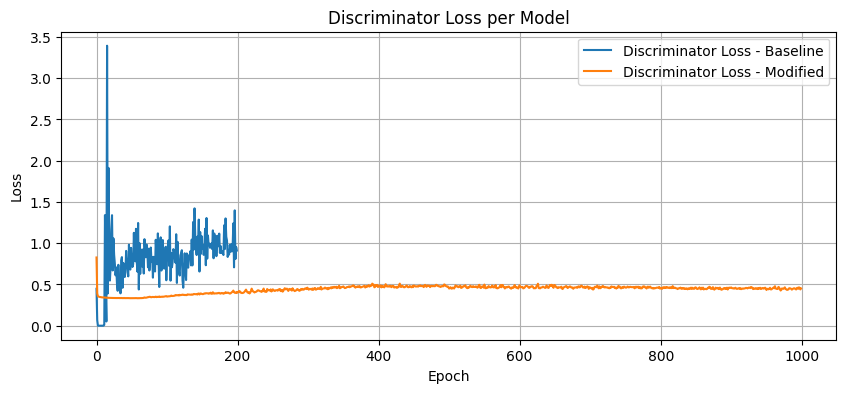

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(d_loss_base, label='Discriminator Loss - Baseline')
plt.plot(d_loss_mod, label='Discriminator Loss - Modified')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss per Model')
plt.legend()
plt.grid(True)
plt.show()


**Analisis FID**


**Kesimpulan Analisis FID Score Model GAN**

Berdasarkan evaluasi dengan metrik **Fréchet Inception Distance (FID)**, dapat disimpulkan bahwa **model Modified secara signifikan mengungguli model Baseline** dalam menghasilkan gambar yang lebih mirip dengan distribusi data asli.

1. Performa Model Baseline:

* Nilai FID terbaik yang dicapai adalah **233.5430 pada epoch 160**.
* Tren FID cenderung tetap tinggi dan fluktuatif sepanjang training, berada di kisaran **250–350**, menandakan hasil gambar yang masih jauh dari kualitas ideal.

2. Performa Model Modified:

* Model ini berhasil mencapai **FID terbaik sebesar 12.10 pada epoch 1000**, menunjukkan peningkatan kualitas gambar yang sangat signifikan.
* FID mengalami penurunan drastis sejak awal training dan kemudian stabil di nilai rendah, yang menunjukkan bahwa **model berhasil belajar menghasilkan gambar yang sangat menyerupai data asli**.

3. Waktu Latih (Epoch) Berperan Penting:

* Hasil ini juga menekankan bahwa **training model GAN memerlukan jumlah epoch yang banyak untuk mencapai performa optimal**.
* Model Modified baru menunjukkan hasil terbaiknya setelah **1000 epoch**, menunjukkan bahwa **GAN membutuhkan waktu pelatihan yang panjang agar generator dan discriminator dapat mencapai keseimbangan dan menghasilkan gambar yang realistis**.
* Ini merupakan karakteristik umum pada GAN—dimana proses training seringkali **lambat konvergensinya dan rentan terhadap ketidakstabilan** bila jumlah epoch terlalu sedikit.

4. Visualisasi:

* Garis FID Score model Modified (oranye) secara konsisten berada jauh di bawah model Baseline (biru) pada seluruh checkpoint, memperkuat bukti bahwa arsitektur atau strategi pelatihan yang dimodifikasi lebih efektif.


Model **Modified GAN** mampu mencapai **FID score yang sangat rendah (12.10)** setelah training yang panjang (1000 epoch), jauh lebih baik dibanding model Baseline yang hanya mencapai **233.5430**. Hasil ini menunjukkan bahwa **GAN sangat memerlukan pelatihan dengan jumlah epoch yang cukup besar** untuk dapat menghasilkan gambar yang berkualitas tinggi dan realistis. Dengan demikian, **kualitas hasil GAN sangat bergantung pada waktu pelatihan yang cukup dan konfigurasi model yang tepat**.


